In [ ]:
"""
To make sure the fusion decomposition works
up to the part where we would stitch the sublimbs together into one limb


"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [2]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu
import neuron_utils as nru

#importing at the bottom so don't get any conflicts
import itertools
from tqdm_utils import tqdm

#for meshparty preprocessing
import meshparty_skeletonize as m_sk
import general_utils as gu
import compartment_utils as cu
from meshparty import trimesh_io
from copy import deepcopy


from neuron_utils import *


# Downloading the Neuron

In [3]:
import datajoint_utils as du

INFO:datajoint.settings:Setting database.host to at-database.ad.bcm.edu
INFO:datajoint.settings:Setting database.user to celiib
INFO:datajoint.settings:Setting database.password to newceliipass
INFO:datajoint.settings:Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO:datajoint.settings:Setting enable_python_native_blobs to True
INFO:datajoint.settings:Setting enable_python_native_blobs to True


Connecting celiib@at-database.ad.bcm.edu:3306


In [4]:
import neuron_visualizations as nviz

In [6]:
segment_id = 864691135404802034

print(f"curr_segment_id = {segment_id}")
current_neuron = du.fetch_segment_id_mesh(segment_id)
nviz.plot_objects(current_neuron)

description = "triple_soma_error"

curr_segment_id = 864691135404802034


/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# Loading the Neuron

In [ ]:
# import trimesh_utils as tu
# curent_neuron = tu.load_mesh_no_processing("/notebooks/test_neurons/Segmentation_2/864691135738362516_thin_long_down_axon.off")
# segment_id = 864691135738362516
# description = "thin_long_down_axon"

# import neuron_visualizations as nviz
# nviz.plot_objects(main_mesh=curent_neuron)

# Setting the Arguments that would be present inside a preprocessing function call

In [7]:
#predefined arguments for the Neuron constructor

decomposition_type="meshafterparty"
mesh_correspondence="meshparty" #meshafterparty_adaptive
distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
meshparty_adaptive_correspondence_after_creation=False
suppress_preprocessing_print=True
computed_attribute_dict=None
somas = None
branch_skeleton_data=None
combine_close_skeleton_nodes = True
combine_close_skeleton_nodes_threshold=700
ignore_warnings=True
suppress_output=False
calculate_spines=True
widths_to_calculate=["no_spine_median_mesh_center"]
fill_hole_size=2000

In [8]:
#arguments for the preprocess neuron
mesh = current_neuron
segment_id=segment_id
description=description

sig_th_initial_split=15 #for significant splitting meshes in the intial mesh split
limb_threshold = 2000 #the mesh faces threshold for a mesh to be qualified as a limb (otherwise too small)
filter_end_node_length=4001 #used in cleaning the skeleton during skeletonizations
return_no_somas = False

decomposition_type=decomposition_type
mesh_correspondence=mesh_correspondence
distance_by_mesh_center=distance_by_mesh_center
meshparty_segment_size =meshparty_segment_size
meshparty_n_surface_downsampling = meshparty_n_surface_downsampling
somas=somas
branch_skeleton_data=branch_skeleton_data
combine_close_skeleton_nodes = combine_close_skeleton_nodes
combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold

# Debugging the soma finding

In [ ]:
# 2: funnel
# 3: closer to soma

In [65]:
nviz.plot_objects(meshes=[list_of_largest_mesh_inner[4]])

In [60]:
nviz.plot_objects(main_mesh=current_neuron,
                  meshes=list_of_largest_mesh_inner,
                  meshes_colors=[[1,0,0,1]])

In [66]:
from soma_extraction_utils import *

current_mesh_verts=current_neuron.vertices
current_mesh_faces=current_neuron.faces
outer_decimation_ratio= 0.25
large_mesh_threshold = 60000
large_mesh_threshold_inner = 40000
soma_width_threshold = 0.32
soma_size_threshold = 15000
inner_decimation_ratio = 0.25
volume_mulitplier=9# old 8
#side_length_ratio_threshold=3,
side_length_ratio_threshold=9
soma_size_threshold_max=192000 #this puts at 12000 once decimated
delete_files=True
backtrack_soma_mesh_to_original=True #should either be None or 
boundary_vertices_threshold=None#700 the previous threshold used
poisson_backtrack_distance_threshold=None#1500 the previous threshold used
close_holes=False

global_start_time = time.time()

#Adjusting the thresholds based on the decimations
large_mesh_threshold = large_mesh_threshold*outer_decimation_ratio
large_mesh_threshold_inner = large_mesh_threshold_inner*outer_decimation_ratio
soma_size_threshold = soma_size_threshold*outer_decimation_ratio
soma_size_threshold_max = soma_size_threshold_max*outer_decimation_ratio

#adjusting for inner decimation
soma_size_threshold = soma_size_threshold*inner_decimation_ratio
soma_size_threshold_max = soma_size_threshold_max*inner_decimation_ratio
print(f"Current Arguments Using (adjusted for decimation):\n large_mesh_threshold= {large_mesh_threshold}"
             f" \nlarge_mesh_threshold_inner = {large_mesh_threshold_inner}"
              f" \nsoma_size_threshold = {soma_size_threshold}"
             f" \nsoma_size_threshold_max = {soma_size_threshold_max}"
             f"\nouter_decimation_ratio = {outer_decimation_ratio}"
             f"\ninner_decimation_ratio = {inner_decimation_ratio}")


# ------------------------------


temp_folder = f"./{segment_id}"
temp_object = Path(temp_folder)
#make the temp folder if it doesn't exist
temp_object.mkdir(parents=True,exist_ok=True)

#making the decimation and poisson objections
Dec_outer = Decimator(outer_decimation_ratio,temp_folder,overwrite=True)
Dec_inner = Decimator(inner_decimation_ratio,temp_folder,overwrite=True)
Poisson_obj = Poisson(temp_folder,overwrite=True)

#Step 1: Decimate the Mesh and then split into the seperate pieces
new_mesh,output_obj = Dec_outer(vertices=current_mesh_verts,
         faces=current_mesh_faces,
         segment_id=segment_id,
         return_mesh=True,
         delete_temp_files=False)

#preforming the splits of the decimated mesh

mesh_splits = new_mesh.split(only_watertight=False)

#get the largest mesh
mesh_lengths = np.array([len(split.faces) for split in mesh_splits])


total_mesh_split_lengths = [len(k.faces) for k in mesh_splits]
ordered_mesh_splits = mesh_splits[np.flip(np.argsort(total_mesh_split_lengths))]
list_of_largest_mesh = [k for k in ordered_mesh_splits if len(k.faces) > large_mesh_threshold]

print(f"Total found significant pieces before Poisson = {list_of_largest_mesh}")

#if no significant pieces were found then will use smaller threshold
if len(list_of_largest_mesh)<=0:
    print(f"Using smaller large_mesh_threshold because no significant pieces found with {large_mesh_threshold}")
    list_of_largest_mesh = [k for k in ordered_mesh_splits if len(k.faces) > large_mesh_threshold/2]

total_soma_list = []
total_classifier_list = []
total_poisson_list = []
total_soma_list_sdf = []

#start iterating through where go through all pieces before the poisson reconstruction
no_somas_found_in_big_loop = 0
for i,largest_mesh in enumerate(list_of_largest_mesh):
    print(f"----- working on large mesh #{i}: {largest_mesh}")

    somas_found_in_big_loop = False

    largest_file_name = str(output_obj.stem) + "_largest_piece.off"
    pre_largest_mesh_path = temp_object / Path(str(output_obj.stem) + "_largest_piece.off")
    pre_largest_mesh_path = pre_largest_mesh_path.absolute()
    print(f"pre_largest_mesh_path = {pre_largest_mesh_path}")
    # ******* This ERRORED AND CALLED OUR NERUON NONE: 77697401493989254 *********
    new_mesh_inner,poisson_file_obj = Poisson_obj(vertices=largest_mesh.vertices,
               faces=largest_mesh.faces,
               return_mesh=True,
               mesh_filename=largest_file_name,
               delete_temp_files=False)


    #splitting the Poisson into the largest pieces and ordering them
    mesh_splits_inner = new_mesh_inner.split(only_watertight=False)
    total_mesh_split_lengths_inner = [len(k.faces) for k in mesh_splits_inner]
    ordered_mesh_splits_inner = mesh_splits_inner[np.flip(np.argsort(total_mesh_split_lengths_inner))]

    list_of_largest_mesh_inner = [k for k in ordered_mesh_splits_inner if len(k.faces) > large_mesh_threshold_inner]
    print(f"Total found significant pieces AFTER Poisson = {list_of_largest_mesh_inner}")

    n_failed_inner_soma_loops = 0
    for j, largest_mesh_inner in enumerate(list_of_largest_mesh_inner):
        print(f"----- working on mesh after poisson #{j}: {largest_mesh_inner}")

        largest_mesh_path_inner = str(poisson_file_obj.stem) + "_largest_inner.off"

        #Decimate the inner poisson piece
        largest_mesh_path_inner_decimated,output_obj_inner = Dec_inner(
                            vertices=largest_mesh_inner.vertices,
                             faces=largest_mesh_inner.faces,
                            mesh_filename=largest_mesh_path_inner,
                             return_mesh=True,
                             delete_temp_files=False)

        print(f"done exporting decimated mesh: {largest_mesh_path_inner}")

        faces = np.array(largest_mesh_path_inner_decimated.faces)
        verts = np.array(largest_mesh_path_inner_decimated.vertices)

        segment_id_new = int(str(segment_id) + f"{i}{j}")

        verts_labels, faces_labels, soma_value,classifier = wcda.extract_branches_whole_neuron(
                                import_Off_Flag=False,
                                segment_id=segment_id_new,
                                vertices=verts,
                                 triangles=faces,
                                pymeshfix_Flag=False,
                                 import_CGAL_Flag=False,
                                 return_Only_Labels=True,
                                 clusters=3,
                                 smoothness=0.2,
                                soma_only=True,
                                return_classifier = True
                                )
        print(f"soma_sdf_value = {soma_value}")

        total_classifier_list.append(classifier)
        #total_poisson_list.append(largest_mesh_path_inner_decimated)

        # Save all of the portions that resemble a soma
        median_values = np.array([v["median"] for k,v in classifier.sdf_final_dict.items()])
        segmentation = np.array([k for k,v in classifier.sdf_final_dict.items()])

        #order the compartments by greatest to smallest
        sorted_medians = np.flip(np.argsort(median_values))
        print(f"segmentation[sorted_medians],median_values[sorted_medians] = {(segmentation[sorted_medians],median_values[sorted_medians])}")
        print(f"Sizes = {[classifier.sdf_final_dict[g]['n_faces'] for g in segmentation[sorted_medians]]}")

        valid_soma_segments_width = [g for g,h in zip(segmentation[sorted_medians],median_values[sorted_medians]) if ((h > soma_width_threshold)
                                                            and (classifier.sdf_final_dict[g]["n_faces"] > soma_size_threshold)
                                                            and (classifier.sdf_final_dict[g]["n_faces"] < soma_size_threshold_max))]
        valid_soma_segments_sdf = [h for g,h in zip(segmentation[sorted_medians],median_values[sorted_medians]) if ((h > soma_width_threshold)
                                                            and (classifier.sdf_final_dict[g]["n_faces"] > soma_size_threshold)
                                                            and (classifier.sdf_final_dict[g]["n_faces"] < soma_size_threshold_max))]

        print("valid_soma_segments_width")
        to_add_list = []
        to_add_list_sdf = []
        if len(valid_soma_segments_width) > 0:
            print(f"      ------ Found {len(valid_soma_segments_width)} viable somas: {valid_soma_segments_width}")
            somas_found_in_big_loop = True
            #get the meshes only if signfiicant length
            labels_list = classifier.labels_list

            for v,sdf in zip(valid_soma_segments_width,valid_soma_segments_sdf):
                submesh_face_list = np.where(classifier.labels_list == v)[0]
                soma_mesh = largest_mesh_path_inner_decimated.submesh([submesh_face_list],append=True)

                # ---------- No longer doing the extra checks in here --------- #


                curr_side_len_check = side_length_check(soma_mesh,side_length_ratio_threshold)
                curr_volume_check = soma_volume_check(soma_mesh,volume_mulitplier)
                if curr_side_len_check and curr_volume_check:
                    to_add_list.append(soma_mesh)
                    to_add_list_sdf.append(sdf)

                else:
                    print(f"--->This soma mesh was not added because it did not pass the sphere validation:\n "
                         f"soma_mesh = {soma_mesh}, curr_side_len_check = {curr_side_len_check}, curr_volume_check = {curr_volume_check}")
                    continue

            n_failed_inner_soma_loops = 0

        else:
            n_failed_inner_soma_loops += 1

        total_soma_list_sdf += to_add_list_sdf
        total_soma_list += to_add_list

        # --------------- KEEP TRACK IF FAILED TO FIND SOMA (IF TOO MANY FAILS THEN BREAK)
        if n_failed_inner_soma_loops >= 2:
            print("breaking inner loop because 2 soma fails in a row")
            break


    # --------------- KEEP TRACK IF FAILED TO FIND SOMA (IF TOO MANY FAILS THEN BREAK)
    if somas_found_in_big_loop == False:
        no_somas_found_in_big_loop += 1
        if no_somas_found_in_big_loop >= 2:
            print("breaking because 2 fails in a row in big loop")
            break

    else:
        no_somas_found_in_big_loop = 0





""" IF THERE ARE MULTIPLE SOMAS THAT ARE WITHIN A CERTAIN DISTANCE OF EACH OTHER THEN JUST COMBINE THEM INTO ONE"""
pairings = []
for y,soma_1 in enumerate(total_soma_list):
    for z,soma_2 in enumerate(total_soma_list):
        if y<z:
            mesh_tree = KDTree(soma_1.vertices)
            distances,closest_node = mesh_tree.query(soma_2.vertices)

            if np.min(distances) < 4000:
                pairings.append([y,z])


#creating the combined meshes from the list
total_soma_list_revised = []
total_soma_list_revised_sdf = []
if len(pairings) > 0:
    """
    Pseudocode: 
    Use a network function to find components

    """


    import networkx as nx
    new_graph = nx.Graph()
    new_graph.add_edges_from(pairings)
    grouped_somas = list(nx.connected_components(new_graph))

    somas_being_combined = []
    print(f"There were soma pairings: Connected components in = {grouped_somas} ")
    for comp in grouped_somas:
        comp = list(comp)
        somas_being_combined += list(comp)
        current_mesh = total_soma_list[comp[0]]
        for i in range(1,len(comp)):
            current_mesh += total_soma_list[comp[i]]

        total_soma_list_revised.append(current_mesh)
        #where can average all of the sdf values
        total_soma_list_revised_sdf.append(np.min(np.array(total_soma_list_sdf)[comp]))

    #add those that weren't combined to total_soma_list_revised
    leftover_somas = [total_soma_list[k] for k in range(0,len(total_soma_list)) if k not in somas_being_combined]
    leftover_somas_sdfs = [total_soma_list_sdf[k] for k in range(0,len(total_soma_list)) if k not in somas_being_combined]
    if len(leftover_somas) > 0:
        total_soma_list_revised += leftover_somas
        total_soma_list_revised_sdf += leftover_somas_sdfs

    print(f"Final total_soma_list_revised = {total_soma_list_revised}")
    print(f"Final total_soma_list_revised_sdf = {total_soma_list_revised_sdf}")


if len(total_soma_list_revised) == 0:
    total_soma_list_revised = total_soma_list
    total_soma_list_revised_sdf = total_soma_list_sdf

run_time = time.time() - global_start_time

print(f"\n\n\n Total time for run = {time.time() - global_start_time}")
print(f"Before Filtering the number of somas found = {len(total_soma_list_revised)}")

#     import system_utils as su
#     su.compressed_pickle(total_soma_list_revised,"total_soma_list_revised")
#     su.compressed_pickle(new_mesh,"original_mesh")

#need to erase all of the temporary files ******
#import shutil
#shutil.rmtree(directory)

"""
Running the extra tests that depend on
- border vertices
- how well the poisson matches the backtracked soma to the real mesh
- other size checks

"""
filtered_soma_list = []
filtered_soma_list_sdf = []
for soma_mesh,curr_soma_sdf in zip(total_soma_list_revised,total_soma_list_revised_sdf):
    if backtrack_soma_mesh_to_original:
        print("Performing Soma Mesh Backtracking to original mesh")
        soma_mesh_poisson = deepcopy(soma_mesh)
        try:
            #print("About to find original mesh")
            soma_mesh = original_mesh_soma(
                                            mesh = new_mesh,
                                            soma_meshes=[soma_mesh_poisson],
                                            sig_th_initial_split=15)[0]
        except:
            import traceback
            traceback.print_exc()
            print("--->This soma mesh was not added because Was not able to backtrack soma to mesh")
            continue
        else:
            if soma_mesh is None:
                print("--->This soma mesh was not added because Was not able to backtrack soma to mesh")
                continue




        print(f"poisson_backtrack_distance_threshold = {poisson_backtrack_distance_threshold}")
        #do the check that tests if there is a max distance between poisson and backtrack:
        if not poisson_backtrack_distance_threshold is None and poisson_backtrack_distance_threshold > 0:

            #soma_mesh.export("soma_mesh.off")
            if close_holes: 
                print("Using the close holes feature")
                fill_hole_obj = meshlab.FillHoles(max_hole_size=2000,
                                                 self_itersect_faces=False)

                soma_mesh_filled_holes,output_subprocess_obj = fill_hole_obj(   
                                                    vertices=soma_mesh.vertices,
                                                     faces=soma_mesh.faces,
                                                     return_mesh=True,
                                                     delete_temp_files=True,
                                                    )
            else:
                soma_mesh_filled_holes = soma_mesh


            #soma_mesh_filled_holes.export("soma_mesh_filled_holes.off")



            print("APPLYING poisson_backtrack_distance_threshold CHECKS")
            mesh_1 = soma_mesh_filled_holes
            mesh_2 = soma_mesh_poisson

            poisson_max_distance = tu.max_distance_betwee_mesh_vertices(mesh_1,mesh_2,
                                                              verbose=True)
            print(f"poisson_max_distance = {poisson_max_distance}")
            if poisson_max_distance > poisson_backtrack_distance_threshold:
                print(f"--->This soma mesh was not added because it did not pass the poisson_backtrack_distance check:\n"
                  f" poisson_max_distance = {poisson_max_distance}")
                continue


    #do the boundary check:
    if not boundary_vertices_threshold is None:
        print("USING boundary_vertices_threshold CHECK")
        soma_boundary_groups_sizes = np.array([len(k) for k in tu.find_border_face_groups(soma_mesh)])
        print(f"soma_boundary_groups_sizes = {soma_boundary_groups_sizes}")
        large_boundary_groups = soma_boundary_groups_sizes[soma_boundary_groups_sizes>boundary_vertices_threshold]
        print(f"large_boundary_groups = {large_boundary_groups} with boundary_vertices_threshold = {boundary_vertices_threshold}")
        if len(large_boundary_groups)>0:
            print(f"--->This soma mesh was not added because it did not pass the boundary vertices validation:\n"
                  f" large_boundary_groups = {large_boundary_groups}")
            continue

    curr_side_len_check = side_length_check(soma_mesh,side_length_ratio_threshold)
    curr_volume_check = soma_volume_check(soma_mesh,volume_mulitplier)
    if (not curr_side_len_check) or (not curr_volume_check):
        print(f"--->This soma mesh was not added because it did not pass the sphere validation:\n "
             f"soma_mesh = {soma_mesh}, curr_side_len_check = {curr_side_len_check}, curr_volume_check = {curr_volume_check}")
        continue

    #tu.write_neuron_off(soma_mesh_poisson,"original_poisson.off")
    #If made it through all the checks then add to final list
    filtered_soma_list.append(soma_mesh)
    filtered_soma_list_sdf.append(curr_soma_sdf)


"""
Need to delete all files in the temp folder *****
"""

if delete_files:
    #now erase all of the files used
    from shutil import rmtree

    #remove the directory with the meshes
    rmtree(str(temp_object.absolute()))

    #removing the temporary files
    temp_folder = Path("./temp")
    temp_files = [x for x in temp_folder.glob('**/*')]
    seg_temp_files = [x for x in temp_files if str(segment_id) in str(x)]

    for f in seg_temp_files:
        f.unlink()

#return total_soma_list, run_time
#return total_soma_list_revised,run_time,total_soma_list_revised_sdf
return_value = filtered_soma_list,run_time,filtered_soma_list_sdf


Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 9919 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/864691135404802034/neuron_864691135404802034.off -o /notebooks/Platinum_Decomp_Fusion/864691135404802034/neuron_864691135404802034_decimated.off -s /notebooks/Platinum_Decomp_Fusion/864691135404802034/decimation_meshlab_25246534.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(115613, 3), faces.shape=(230207, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(115613, 3), faces.shape=(230207, 3))>
pre_largest_mesh_path = /notebooks/Platinum_Decomp_Fusion/864691135404802034/neuron_864691135404802034_decimated_largest_piece.off
xvfb-run -n 2111 -s "-screen 0 800x600x24" meshlabserver $@  -i /noteb

xvfb-run -n 9991 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_630813.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_630813_poisson.off -s /notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_14332.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_630813.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_630813_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_14332.mls is being deleted....
Inside sphere validater: ratio_val = 148.73814230297188
--->This soma mesh was not added because it did not pass the sphere validation:
 soma_mesh = <trimesh.Trimesh(vertices.shape=(1228, 3), faces.shape=(2444, 3))>, curr_side_len_check = True, curr_volume_check = False
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 8790 -s "-screen 0 800x600x24" meshlabserver $@  -i /not

done exporting decimated mesh: neuron_864691135404802034_decimated_largest_piece_poisson_largest_inner.off
1) Starting: Mesh importing and Pymesh fix
loading mesh from vertices and triangles array
1) Finished: Mesh importing and Pymesh fix: 0.0002548694610595703
2) Staring: Generating CGAL segmentation for neuron
Done writing OFF file

Starting CGAL segmentation
Right before cgal segmentation, clusters = 3, smoothness = 0.2, path_and_filename = /notebooks/Platinum_Decomp_Fusion/temp/86469113540480203404_fixed 
1
Finished CGAL segmentation algorithm: 0.27434492111206055
2) Finished: Generating CGAL segmentation for neuron: 0.34489965438842773
3) Staring: Generating Graph Structure and Identifying Soma using soma size threshold  = 3000
my_list_keys = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
soma_index = -1
3) Finished: Generating Graph Structure and Identifying Soma: 0.001361846923828125
Not finding the apical because soma_only option selected
6) Staring: Classifying Entire Neuron
Total Labels

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_902633.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_902633_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_671941.mls is being deleted....
Inside sphere validater: ratio_val = 7.710012629788693
Performing Soma Mesh Backtracking to original mesh
# total split meshes = 7
viable_meshes = [0]
There were 6 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


----Working on soma-containing mesh piece 0----
current_soma_mesh_list = [<trimesh.Trimesh(vertices.shape=(624, 3), faces.shape=(1201, 3))>]
current_mesh = <trimesh.Trimesh(vertices.shape=(115613, 3), faces.shape=(229910, 3))>

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(84498, 3), faces.shape=(167168, 3))>, <trimesh.Trimesh(vertices.sha

In [52]:
import neuron_visualizations as nviz

In [67]:
nviz.plot_objects(meshes=total_soma_list,
                 meshes_colors="random")

# Setting up the metadata

In [9]:
whole_processing_tiempo = time.time()


"""
Purpose: To process the mesh into a format that can be loaded into the neuron class
and used for higher order processing (how to visualize is included)

"""
if description is None:
    description = "no_description"
if segment_id is None:
    #pick a random segment id
    segment_id = np.random.randint(100000000)
    print(f"picking a random 7 digit segment id: {segment_id}")
    description += "_random_id"


if mesh is None:
    if current_mesh_file is None:
        raise Exception("No mesh or mesh_file file were given")
    else:
        current_neuron = trimesh.load_mesh(current_mesh_file)
else:
    current_neuron = mesh

# ************************ Phase A: Soma and Limb Identification ********************************

In [10]:
# --- 1) Doing the soma detection
if somas is None:
    soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)
else:
    soma_mesh_list,run_time,total_soma_list_sdf = somas

# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
    if return_no_somas:
        return_value= soma_mesh_list_centers
    raise Exception("Processing of No Somas is not yet implemented yet")
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 7605 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/864691135404802034/neuron_864691135404802034.off -o /notebooks/Platinum_Decomp_Fusion/864691135404802034/neuron_864691135404802034_decimated.off -s /notebooks/Platinum_Decomp_Fusion/864691135404802034/decimation_meshlab_25252742.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(115613, 3), faces.shape=(230207, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(115613, 3), faces.shape=(230207, 3))>
pre_largest_mesh_path = /notebooks/Platinum_Decomp_Fusion/864691135404802034/neuron_864691135404802034_decimated_largest_piece.off
xvfb-run -n 981 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebo

Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 7472 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_178528.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_178528_poisson.off -s /notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_948386.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_178528.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_178528_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_948386.mls is being deleted....
Inside sphere validater: ratio_val = 148.73814230297188
--->This soma mesh was not added because it did not pass the sphere validation:
 soma_mesh = <trimesh.Trimesh(vertices.shape=(1228, 3), faces.shape=(2444, 3))>, curr_side_len_check = True, curr_volume_check = False
Using Poisson Surface Reconstruction for watertightness in soma_vo

xvfb-run -n 4649 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/864691135404802034/neuron_864691135404802034_decimated_largest_piece_poisson_largest_inner.off -o /notebooks/Platinum_Decomp_Fusion/864691135404802034/neuron_864691135404802034_decimated_largest_piece_poisson_largest_inner_decimated.off -s /notebooks/Platinum_Decomp_Fusion/864691135404802034/decimation_meshlab_25247438.mls
done exporting decimated mesh: neuron_864691135404802034_decimated_largest_piece_poisson_largest_inner.off
1) Starting: Mesh importing and Pymesh fix
loading mesh from vertices and triangles array
1) Finished: Mesh importing and Pymesh fix: 0.00023317337036132812
2) Staring: Generating CGAL segmentation for neuron
Done writing OFF file

Starting CGAL segmentation
Right before cgal segmentation, clusters = 3, smoothness = 0.2, path_and_filename = /notebooks/Platinum_Decomp_Fusion/temp/86469113540480203404_fixed 
1
Finished CGAL segmentation algorithm: 0.2555103302001953
2

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_89248.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_89248_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_234762.mls is being deleted....
Inside sphere validater: ratio_val = 7.710012629788693
Performing Soma Mesh Backtracking to original mesh
# total split meshes = 7
viable_meshes = [0]
There were 6 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


----Working on soma-containing mesh piece 0----
current_soma_mesh_list = [<trimesh.Trimesh(vertices.shape=(686, 3), faces.shape=(1305, 3))>]
current_mesh = <trimesh.Trimesh(vertices.shape=(115613, 3), faces.shape=(229910, 3))>

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(109567, 3), faces.shape=(217722, 3))>, <trimesh.Trimesh(vertices.shap

In [11]:
#--- 2) getting the soma submeshes that are connected to each soma and identifiying those that aren't (and eliminating any mesh pieces inside the soma)

main_mesh_total = current_neuron


#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list,
                                        split_meshes)

# filtering away any of the inside floating pieces: 
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """

    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)                                                      


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]


#     print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
#     print(f"# of inside pieces = {len(inside_pieces)}")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")






# total split meshes = 25
There were 24 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0, 1]}


In [12]:
tu = reload(tu)
#--- 3)  Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

#     sk.graph_skeleton_and_mesh(other_meshes=[soma_meshes])

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


"""

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print(f"\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    current_time = time.time()
    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)
    print(f"Total time for Subtract Soam = {time.time() - current_time}")
    current_time = time.time()

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)

    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    print(f"Total time for Original_mesh_faces_map for mesh_pieces without soma= {time.time() - current_time}")
    current_time = time.time()
    soma_meshes = current_mesh.submesh([soma_faces],append=True,repair=False)

    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True,repair=False)

    print(f"Total time for Original_mesh_faces_map for somas= {time.time() - current_time}")
    current_time = time.time()

    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)

    print(f"Total time for sig_non_soma_pieces= {time.time() - current_time}")
    current_time = time.time()

    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces

    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    #take the top largest ones depending how many were originally in the soma list
    seperate_soma_meshes = seperate_soma_meshes[:len(soma_mesh_list)]
    soma_face_components = soma_face_components[:len(soma_mesh_list)]

    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes

    print(f"Total time for split= {time.time() - current_time}")
    current_time = time.time()



    soma_to_piece_connectivity = dict()
    soma_to_piece_touching_vertices = dict()
    soma_to_piece_touching_vertices_idx = dict()
    limb_root_nodes = dict()
    
    m_vert_graph = tu.mesh_vertex_graph(current_mesh)
    
    for i,curr_soma in enumerate(seperate_soma_meshes):
        (connected_mesh_pieces,
         connected_mesh_pieces_vertices,
         connected_mesh_pieces_vertices_idx) = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True,
                        return_vertices_idx=True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces

        soma_to_piece_touching_vertices[i] = dict()
        for piece_index,piece_idx in enumerate(connected_mesh_pieces):
            limb_root_nodes[piece_idx] = connected_mesh_pieces_vertices[piece_index][0]
            
            """ Old way of finding vertex connected components on a mesh without trimesh function
            #find the number of touching groups and save those 
            soma_touching_graph = m_vert_graph.subgraph(connected_mesh_pieces_vertices_idx[piece_index])
            soma_con_comp = [current_mesh.vertices[np.array(list(k)).astype("int")] for k in list(nx.connected_components(soma_touching_graph))]
            soma_to_piece_touching_vertices[i][piece_idx] = soma_con_comp
            """
            
            soma_to_piece_touching_vertices[i][piece_idx] = tu.split_vertex_list_into_connected_components(
                                                vertex_indices_list=connected_mesh_pieces_vertices_idx[piece_index],
                                                mesh=current_mesh, 
                                                vertex_graph=m_vert_graph, 
                                                return_coordinates=True
                                               )
            
            
            
            

#         border_debug = False
#         if border_debug:
#             print(f"soma_to_piece_connectivity = {soma_to_piece_connectivity}")
#             print(f"soma_to_piece_touching_vertices = {soma_to_piece_touching_vertices}")


    print(f"Total time for mesh_pieces_connectivity= {time.time() - current_time}")

    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")



# Lets have an alert if there was more than one soma disconnected meshes
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

current_mesh_data = soma_touching_mesh_data
soma_containing_idx = 0

#doing inversion of the connectivity and touching vertices
piece_to_soma_touching_vertices = gu.flip_key_orders_for_dict(soma_to_piece_touching_vertices)


# ****Soma Touching mesh Data has the branches and the connectivity (So this is where you end up skipping if you don't have somas)***



----Working on soma-containing mesh piece 0----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(316685, 3), faces.shape=(631560, 3))>, <trimesh.Trimesh(vertices.shape=(55217, 3), faces.shape=(110085, 3))>, <trimesh.Trimesh(vertices.shape=(18797, 3), faces.shape=(37229, 3))>, <trimesh.Trimesh(vertices.shape=(15316, 3), faces.shape=(30417, 3))>, <trimesh.Trimesh(vertices.shape=(10233, 3), faces.shape=(20168, 3))>, <trimesh.Trimesh(vertices.shape=(7844, 3), faces.shape=(15687, 3))>, <trimesh.Trimesh(vertices.shape=(7519, 3), faces.shape=(14999, 3))>, <trimesh.Trimesh(vertices.shape=(3084, 3), faces.shape=(6119, 3))>, <trimesh.Trimesh(vertices.shape=(2972, 3), faces.shape=(5932, 3))>, <trimesh.Trimesh(vertices.shape=(1586, 3), faces.shape=(3164, 3))>]
There were 10 pieces found after size threshold
mesh pieces in subtact soma AFTER the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(316685, 3), faces.

In [69]:
nviz.plot_objects(meshes=soma_mesh_list)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# Process that will start for each limb

In [121]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
m_sk = reload(m_sk)
pre = reload(pre)
xu = reload(xu)
nu = reload(nu)
gu = reload(gu)

try:
    proper_time = time.time()

    #The containers that will hold the final data for the preprocessed neuron
    limb_correspondence=dict()
    limb_network_stating_info = dict()

    # ---------- Part A: skeletonization and mesh decomposition --------- #
    skeleton_time = time.time()

    for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):

        #Arguments to pass to the specific function (when working with a limb)
        soma_touching_vertices_dict = piece_to_soma_touching_vertices[curr_limb_idx]

    #     if curr_limb_idx != 10:
    #         continue

        curr_limb_time = time.time()
        print(f"\n\n----- Working on Proper Limb # {curr_limb_idx} ---------")


        limb_correspondence_individual,network_starting_info = pre.preprocess_limb(mesh=limb_mesh_mparty,
                       soma_touching_vertices_dict = soma_touching_vertices_dict,
                       return_concept_network = False, 
                       return_concept_network_starting_info=True,
                       width_threshold_MAP=500,
                       size_threshold_MAP=2000,
                       surface_reconstruction_size=1000,                                                            
                       )
        #Storing all of the data to be sent to 

        limb_correspondence[curr_limb_idx] = limb_correspondence_individual
        limb_network_stating_info[curr_limb_idx] = network_starting_info

    #     raise Exception("Done with #10")


    print(f"Total time for Skeletonization and Mesh Correspondence = {time.time() - skeleton_time}")

    pre=reload(pre)
    neuron=reload(neuron)
    nru = reload(nru)
    # ---------- Part B: Stitching on floating pieces --------- #
    floating_stitching_time = time.time()

    limb_correspondence_with_floating_pieces = pre.attach_floating_pieces_to_limb_correspondence(
            limb_correspondence,
            floating_meshes=non_soma_touching_meshes,
            floating_piece_face_threshold = 600,
            max_stitch_distance=8000,
            distance_to_move_point_threshold = 4000,
            verbose = False)



    print(f"Total time for stitching floating pieces = {time.time() - floating_stitching_time}")





    # ---------- Part C: Computing Concept Networks --------- #
    concept_network_time = time.time()

    limb_concept_networks=dict()
    limb_labels=dict()

    for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
        limb_to_soma_concept_networks = pre.calculate_limb_concept_networks(limb_correspondence_with_floating_pieces[curr_limb_idx],
                                                                            run_concept_network_checks=True,
                                                                           **limb_network_stating_info[curr_limb_idx])   



        limb_concept_networks[curr_limb_idx] = limb_to_soma_concept_networks
        limb_labels[curr_limb_idx]= "Unlabeled"

    print(f"Total time for Concept Networks = {time.time() - concept_network_time}")





    preprocessed_data= dict(
        soma_meshes = current_mesh_data[0]["soma_meshes"],
        soma_to_piece_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"],
        soma_sdfs = total_soma_list_sdf,
        insignificant_limbs=insignificant_limbs,
        non_soma_touching_meshes=non_soma_touching_meshes,
        inside_pieces=inside_pieces,
        limb_correspondence=limb_correspondence_with_floating_pieces,
        limb_concept_networks=limb_concept_networks,
        limb_network_stating_info=limb_network_stating_info,
        limb_labels=limb_labels,
        limb_meshes=current_mesh_data[0]["branch_meshes"],
        )



    print(f"Total time for all limb decomps = {time.time() - proper_time}")

    #864049.29563888 1004924.982468    884750.28428994

    neuron_obj = neuron.Neuron(
                    mesh=current_neuron,
                     segment_id=segment_id,
                     description=description,
                     preprocessed_data=preprocessed_data,
    #                  decomposition_type="meshafterparty",
    #                  mesh_correspondence="meshparty", #meshafterparty_adaptive
    #                  distance_by_mesh_center=True, #how the distance is calculated for mesh correspondence
    #                  meshparty_segment_size = 0,
    #                  meshparty_n_surface_downsampling = 0,
    #                  meshparty_adaptive_correspondence_after_creation=False,
    #                 suppress_preprocessing_print=True,
    #                  computed_attribute_dict=None,
    #                  somas = None,
    #                  branch_skeleton_data=None,
    #                  combine_close_skeleton_nodes = True,
    #                 combine_close_skeleton_nodes_threshold=700,


                    ignore_warnings=True,
                    suppress_output=False,
                    calculate_spines=True,
                    widths_to_calculate=["no_spine_median_mesh_center"]
                    )

except gu.CGAL_skel_error as error: 
    print("The CGAL error was encountered")



----- Working on Proper Limb # 0 ---------
Time for preparing soma vertices and root: 1.049041748046875e-05
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:15<00:00, 15.85s/it]

Time for 1st pass MP skeletonization: 19.234410047531128
connecting at the root
branches_touching_root = [145]
length of Graph = 29833
Working on path [3197. 3223. 3245. 3279. 3329. 3373. 3419. 3427.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
Working on path [6643. 6684. 6715. 6748. 6774. 6816. 6857. 6870.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
Working on path [7340. 7413. 7425.]
path_degrees = [3, 2, 3]
Working on path [18801. 18815. 18827. 18835.]
path_degrees = [3, 2, 2, 3]
Working on path [22425. 22458. 22477. 22493. 22519. 22546. 22574. 22578.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 145, len(kept_branches_idx) = 141
empty_indices % = 0.0
 conflict_indices % = 0.012148948131022415



AFTER face_lookup_resolved_test



Decomposing first pass: 22.5016770362854
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [1081, 1299, 1486, 1276, 8115, 842, 70, 1338, 33419, 7410, 13341, 2817, 235, 2777, 199, 365, 1765, 6172, 22408, 1781, 125, 14007, 2260, 3764, 2592, 1944, 2195, 1274, 1289, 7962, 2634, 47626, 160, 6612, 7829, 3171, 31392, 5823, 5533]
mesh_large_connectivity: 1.7870686054229736
Finding MAP candidates connected components: 0.00045299530029296875
len(filtered_pieces) = 4
skeleton_connectivity_MP : 0.9415593147277832
Grouping MP Sublimbs by Graph: 0.24352145195007324
Divinding into MP and MAP pieces: 1.430511474609375e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.01626276969909668
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 1529 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusi


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.08940792083740234
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 62.61135125160217
Checking connected components after removing cycles
Total time for mesh KDTree = 1.4821436405181885
sbv[0].reshape(-1,3) = [[532406.  924555.6 654631.6]]
closest_sk_pt_coord BEFORE = [530313. 922903. 655538.]
current_skeleton.shape = (1790, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [530313. 922903. 655538.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[530313., 922903., 655538.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 2.1378180980682373
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[530313. 922903. 655538.]]
Number of end_nodes B


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1675, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 66.98095321655273
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 35.32757925987244
mesh_correspondence_first_pass: 35.327605962753296
Limb decomposed into 12 branches
divided_skeleton_graph_recovered = (1675, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1675, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (11, 12)
empty_indices % = 0.07375760248271501
 conflict_indices % = 0.016016174255975905



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 114.10663032531738
correspondence_1_to_1: 11.781768560409546
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.005322933197021484
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 7046 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_841034.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 4573 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_45865.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_45865_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_818680.m


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.02833080291748047
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 7.043612718582153
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.002313375473022461
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (36, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 7.102119207382202
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.4020559787750244
mesh_correspondence_first_pass: 0.4020843505859375
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (36, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (36, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.22703193582563946
 conflict_indices % = 0.05509308309368851



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 7.696943044662476
correspondence_1_to_1: 0.18740129470825195
--- Working on MAP piece 2---
MAP Filtering Soma Pieces: 0.007124662399291992
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 3233 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_32419.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8063 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_54227.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_54227_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_420280.ml


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.022008895874023438
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.182660341262817
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.0017006397247314453
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (21, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 6.224635362625122
Working on limb correspondence for #2 MAP piece



Total time for decomposition = 0.17583823204040527
mesh_correspondence_first_pass: 0.17586922645568848
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (21, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (21, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.2702783597725232
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #2 mesh processing = 6.518781423568726
correspondence_1_to_1: 0.11118364334106445
--- Working on MAP piece 3---
MAP Filtering Soma Pieces: 0.005627155303955078
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 3925 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_810728.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 2052 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_83039.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_83039_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_445046.m


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.021115779876708984
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 8.538810968399048
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.0010616779327392578
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (3, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 8.573386907577515
Working on limb correspondence for #3 MAP piece



Total time for decomposition = 0.21378612518310547
mesh_correspondence_first_pass: 0.2138350009918213
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (3, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (3, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.2581143740340031
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #3 mesh processing = 8.938074827194214
correspondence_1_to_1: 0.1452014446258545
Total time for MAP sublimb processing 137.26087379455566
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.007668733596801758
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.005163908004760742
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.006676197052001953
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.002245187759399414
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.004320621490478516
Fixing Possible Soma Extension Branch for Sublimb 4
Total time for mesh KDTree = 0.38187527656555176
sbv[0].reshape(-1,3) = [[477573.4 796517.4 605912.5]]
closest_sk_pt_co




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.26890553273737616
 conflict_indices % = 0.24402029475718773



AFTER face_lookup_resolved_test
Took 12 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 238.2911919532144
curr_width_median = 403.6442428465955
curr_width_median = 211.5488246063537
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 2.0370187759399414
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.011496305465698242
Do Not Need to Fix MP Decomposition 5 so just continuing
---- Working on MP Decomposition #6 ----
MP filtering soma verts: 0.009412288665771484
Do Not Need to Fix MP Decomposition 6 so just continuing
---- Working on MP Decomposition #7 ----
MP filtering soma verts: 0.006404399871826172
Do Not Need to Fix MP Decomposition 7 so just continuing
---- Working on MP Decomposition #8 ----
MP filtering soma verts: 0.006574153900146484
Do Not Need to Fix MP Decomposition 8 so just continuing
---- Working on MP Decomposition #9 ----
MP filtering soma verts: 0.006748199462890625
Do Not Need to Fix MP Decomposition 9 so just continuing
---- Working on MP Decomposition #10 ----
MP filte




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.058414225581994675
 conflict_indices % = 0.007989004381066919



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (3, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 47383.49587252275
conn = [1]
winning_vertex = [491634.2666242  803621.97512735 604788.9653717 ]
MP_branches_with_stitch_point = [1]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (712.1041036300245) 
Found winning edge: [14, 15.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.09667836197403129
 conflict_indices % = 0.0032140753450969344



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (6, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 47701.92201996924
conn = [0]
winning_vertex = [519814.08296167 879395.70339321 639573.76051244]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [13]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (755.8245139760262) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.09958875840669863
 conflict_indices % = 0.01238178659975949



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 16877.32059401577
conn = [0]
winning_vertex = [490199.36744296 775705.66139299 596644.53032056]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (328.2182959735185) 
Found winning edge: [44, 45.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.22096893491124261
 conflict_indices % = 0.0234375



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 7433.031895037413
conn = [0]
winning_vertex = [533408.32438613 846453.57819728 620165.48807755]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (427.6715538902837) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0596819674990552
 conflict_indices % = 0.019390098549376435



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (8, 0) 




---- Working on (9, 0) connection-----
Current stitch point was a branch or endpoint
conn = [0, 1]
winning_vertex = [525752.11239641 934766.16607615 660193.75163384]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (561.7992553535767) 
Found winning edge: [1083, 1085.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (474.83451052953075) 
Found winning edge: [321, 322.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06975147604009337
 conflict_indices % = 0.008890567074007963



AFTER face_lookup_resolved_test



 Finished with (9, 0) 




---- Working on (10, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 14503.272064397772
conn = [0]
winning_vertex = [545245.44404637 886617.10691776 653133.67613343]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [12]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (521.2597464900375) 
Only 2 skeleton nodes so cannot do smoothing





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06069246435845214
 conflict_indices % = 0.15254582484725052



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (10, 0) 




---- Working on (12, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 66300.50444038793
conn = [0]
winning_vertex = [514502.75702983 864012.21368357 635432.68430656]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [13]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (628.6639899116088) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10243797504660834
 conflict_indices % = 0.018542951383909365



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (12, 0) 




---- Working on (13, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2893.498013689135
conn = [0]
winning_vertex = [547115.39761356 895751.69333975 659055.94070947]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [17]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (534.5609908174739) 
Only 2 skeleton nodes so cannot do smoothing





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08354359405663023
 conflict_indices % = 0.17269414073451078



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (13, 0) 




---- Working on (14, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 18491.539312651807
conn = [0]
winning_vertex = [541481.39395669 880342.77062276 648353.58811404]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [9]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (941.0726483173993) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05985552115583075
 conflict_indices % = 0.0060445230723868495



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (14, 0) 




---- Working on (15, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 25960.9246916705
conn = [0]
winning_vertex = [592710.53714307 907646.83037    609639.24355687]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [10]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [7, 8.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07664938497509403
 conflict_indices % = 0.002473653891769171



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (15, 0) 




---- Working on (16, 0) connection-----
Current stitch point was a branch or endpoint
conn = [0, 1]
winning_vertex = [586023.77357031 998998.46585773 717672.28494611]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [11]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [5, 6.0]
in remove edge
Found winning edge: [1153, 1154.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.042398612014747344
 conflict_indices % = 0.0035009449453170987



AFTER face_lookup_resolved_test



 Finished with (16, 0) 




---- Working on (17, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 8919.855835279377
conn = [0]
winning_vertex = [545516.59674135 890515.06415921 656782.18636028]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [17]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (712.0977360394091) 
Found winning edge: [13, 14.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.28484848484848485
 conflict_indices % = 0.044848484848484846



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (17, 0) 




---- Working on (18, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 7319.132213762542
conn = [0]
winning_vertex = [527453.62248508 914287.67149653 653482.98818268]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [14]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1073.438830769676) 
Found winning edge: [1203, 1204.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04726888622559873
 conflict_indices % = 0.018627231916146986



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (18, 0) 




---- Working on (19, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 13376.977566853198
conn = [0]
winning_vertex = [539100.75098541 875923.59046601 645833.00343588]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [9]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (638.6630429653547) 
Found winning edge: [4, 5.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.045588235294117645
 conflict_indices % = 0.046875



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (19, 0) 




---- Working on (21, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1749.867933054859
conn = [0]
winning_vertex = [529848.62330617 840025.59807851 615082.58698368]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (359.0270189893022) 
Found winning edge: [70, 71.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07937752827540659
 conflict_indices % = 0.00191942541071576



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (21, 0) 




---- Working on (22, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 8464.535318139717
conn = [0, 1]
winning_vertex = [534591.44833297 847494.80840936 633542.57333948]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1645.1416553504575) 
Found winning edge: [244, 246.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1558.0748329635044) 
Found winning edge: [45, 46.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.08232738816256631
 conflict_indices % = 0.05968840065160185



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (22, 0) 




---- Working on (1, 1) connection-----
Current stitch point was a branch or endpoint
conn = [0, 1]
winning_vertex = [495474.66629438 803333.01165932 619609.92776498]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (984.3419095271371) 
Found winning edge: [42, 43.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1107.1775109428124) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10384850335980451
 conflict_indices % = 0.022602321319486866



AFTER face_lookup_resolved_test



 Finished with (1, 1) 




---- Working on (2, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 599.3871870502405
conn = [0, 1]
winning_vertex = [494392.8452172  805246.12234862 617733.48263817]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1466.8698312493698) 
Found winning edge: [20, 21.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1507.560967430177) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.07957559681697612
 conflict_indices % = 0.4554755589238348



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 1) 




---- Working on (3, 1) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 3155.158892732134
conn = [0, 4]
winning_vertex = [491317.41821678 803405.74763828 612536.37311835]
MP_branches_with_stitch_point = [0, 4]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (2415.7336612487916) 
Found winning edge: [48, 49.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (2499.8749983007265) 
Found winning edge: [54, 55.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.22149837133550487
 conflict_indices % = 0.07136511696772282



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 1) 




---- Working on (5, 1) connection-----
Current stitch point was a branch or endpoint
conn = [3, 20]
winning_vertex = [494162.73589541 800186.44128111 614393.47086893]
MP_branches_with_stitch_point = [3, 20]
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (654.4012974597122) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (535.9368160730313) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12075583111898436
 conflict_indices % = 0.06643046944198405



AFTER face_lookup_resolved_test



 Finished with (5, 1) 




---- Working on (3, 2) connection-----
Current stitch point was a branch or endpoint
conn = [3, 4]
winning_vertex = [487700.92577077 799838.98040503 609044.97624119]
MP_branches_with_stitch_point = [3, 4]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1642.5929069866913) 
Found winning edge: [70, 72.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1688.2845592147473) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.14783149385978547
 conflict_indices % = 0.004041660189647132



AFTER face_lookup_resolved_test



 Finished with (3, 2) 




---- Working on (4, 2) connection-----
Current stitch point was a branch or endpoint
conn = [5, 16]
winning_vertex = [483579.18280731 790730.1696743  604942.33876758]
MP_branches_with_stitch_point = [5, 16]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (2104.563668399076) 
Found winning edge: [37, 38.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (2069.484476165938) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.29933122657455724
 conflict_indices % = 0.014477842287058132



AFTER face_lookup_resolved_test



 Finished with (4, 2) 




---- Working on (11, 2) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1936.2208840133312
conn = [0]
winning_vertex = [486146.87186283 797247.07668268 607678.82914641]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (622.4484527135393) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05704157267160812
 conflict_indices % = 0.04640670319046084



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (11, 2) 




---- Working on (20, 2) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 224.5773808734976
Changing the stitch point becasue the distance to end or branch node was 224.5773808734976
New stitch point has degree 1
conn = [0]
winning_vertex = [486461.44463502 798386.63842361 608071.65718234]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (583.9861833169118) 
Found winning edge: [43, 44.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.08293153326904533
 conflict_indices % = 0.06075216972034716



AFTER face_lookup_resolved_test



 Finished with (20, 2) 




---- Working on (4, 3) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1737.2141491479972
conn = [15, 16]
winning_vertex = [484887.77076802 785105.55069157 599750.47645471]
MP_branches_with_stitch_point = [15, 16]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (3058.6483834342107) 
Found winning edge: [36, 37.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (3039.3060138077435) 
Found winning edge: [87, 88.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.23906614785992217
 conflict_indices % = 0.3107782101167315



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (4, 3) 



Time for decomp of Limb = 298.6775789260864


----- Working on Proper Limb # 1 ---------
Time for preparing soma vertices and root: 6.9141387939453125e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

Time for 1st pass MP skeletonization: 1.174109697341919
connecting at the root
branches_touching_root = [21]
length of Graph = 6765
Working on path [2008. 2010. 2015. 2020. 2027. 2031. 2034.]
path_degrees = [3, 2, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 21, len(kept_branches_idx) = 21
empty_indices % = 0.0
 conflict_indices % = 0.0038252557742281344



AFTER face_lookup_resolved_test



Decomposing first pass: 4.560433864593506
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [30831]
mesh_large_connectivity: 0.0002942085266113281
Finding MAP candidates connected components: 8.296966552734375e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.23835015296936035
Grouping MP Sublimbs by Graph: 0.04302096366882324
Divinding into MP and MAP pieces: 1.430511474609375e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.001893758773803711
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 4853 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_230690.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
remov


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.028429031372070312
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 12.67601728439331
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.010125160217285156
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (255, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 12.875513076782227
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 3.040485143661499
mesh_correspondence_first_pass: 3.040513753890991
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (255, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (255, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.06856735104278161
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 16.407274961471558
correspondence_1_to_1: 0.4893310070037842
Total time for MAP sublimb processing 16.40735363960266
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.007100105285644531
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.4987168312072754
sbv[0].reshape(-1,3) = [[529809. 935151. 658959.]]
closest_sk_pt_coord BEFORE = [525804.35471151 936826.19411636 657311.69654592]
current_skeleton.shape = (5624, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 100107.8833113678
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [525804.35471151 936826.19411636 657311.69654592]
Adding new branch to skeleton
border_average_coordinate = [529641.825      934844.27857143 658870.27857143]
endpoints_must_keep = {0: array([[529641.825     , 934844.27857143, 658870.27857143]])}
MP (because soma touching verts) create_soma_extend




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11137335890249299
 conflict_indices % = 0.01010473521168314



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 758.6355737291813
curr_width_median = 443.4086677305204
curr_width_median = 903.8728044506288
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 4.921583414077759

---- Working on (0, 0) connection-----
Current stitch point was a branch or endpoint
conn = [5, 19]
winning_vertex = [517805.08888578 932208.02944216 655854.75484254]
MP_branches_with_stitch_point = [5, 19]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (476.3560662332409) 
Found winning edge: [1080, 1081.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (493.21810071447766) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06997943233237351
 conflict_indices % = 0.00781571369806664



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


 Finished with (0, 0) 



Time for decomp of Limb = 41.48334717750549


----- Working on Proper Limb # 2 ---------
Time for preparing soma vertices and root: 8.106231689453125e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

Time for 1st pass MP skeletonization: 0.33545827865600586
branches_touching_root = [2]
length of Graph = 1527
max(kept_branches_idx) = 6, len(kept_branches_idx) = 7
empty_indices % = 0.0
 conflict_indices % = 0.00746729699965081



AFTER face_lookup_resolved_test



Decomposing first pass: 0.8892641067504883
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [8688, 4819, 8502]
mesh_large_connectivity: 0.008951902389526367
Finding MAP candidates connected components: 9.34600830078125e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.03829360008239746
Grouping MP Sublimbs by Graph: 0.00909113883972168
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0013613700866699219
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 7833 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_558753.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/No


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.03209495544433594
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 12.029110193252563
Checking connected components after removing cycles
Total time for mesh KDTree = 0.1548607349395752
sbv[0].reshape(-1,3) = [[539889. 926898. 648060.]]
closest_sk_pt_coord BEFORE = [540406. 925694. 646943.]
current_skeleton.shape = (188, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [540406. 925694. 646943.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[540406., 925694., 646943.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.22398090362548828
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[540406. 925694. 646943.]]
Number of end_nodes BEF


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (178, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 12.391566753387451
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 1.3874938488006592
mesh_correspondence_first_pass: 1.3875200748443604
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (178, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (178, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.04320959607433323
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 14.541344165802002
correspondence_1_to_1: 0.7608754634857178
Total time for MAP sublimb processing 14.541449785232544
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.005654811859130859
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.001556396484375
Do Not Need to Fix MP Decomposition 1 so just continuing

---- Working on (0, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 29027.49225047363
conn = [1]
winning_vertex = [535408.48295474 908398.49458641 624867.09045308]
MP_branches_with_stitch_point = [1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1137.435235612222) 
Found winning edge: [107, 108.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05380260501207491
 conflict_indices % = 0.03697691911793816



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 15321.69019875387
conn = [0]
winning_vertex = [542234.87306329 889036.81309973 604914.02846134]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (422.95740801983686) 
Found winning edge: [70, 71.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.053110221898872316
 conflict_indices % = 0.01280465623863223



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (1, 0) 



Time for decomp of Limb = 20.43601703643799


----- Working on Proper Limb # 3 ---------
Time for preparing soma vertices and root: 5.4836273193359375e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 10.73it/s]

Time for 1st pass MP skeletonization: 0.28869032859802246
connecting at the root
branches_touching_root = [2]
length of Graph = 1095
max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.0020712101785185914



AFTER face_lookup_resolved_test



Decomposing first pass: 0.7228894233703613
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [3936, 25930]
mesh_large_connectivity: 0.006142377853393555
Finding MAP candidates connected components: 8.20159912109375e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.011362552642822266
Grouping MP Sublimbs by Graph: 0.0014197826385498047
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0032355785369873047
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 1717 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_449288.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.033751726150512695
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 12.40262222290039
Checking connected components after removing cycles
Total time for mesh KDTree = 0.1981201171875
sbv[0].reshape(-1,3) = [[542901.8 929201.9 650048.9]]
closest_sk_pt_coord BEFORE = [543205. 928968. 650117.]
current_skeleton.shape = (232, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [543205. 928968. 650117.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[543205., 928968., 650117.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.2793409824371338
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[543205. 928968. 650117.]]
Number of end_nodes BEFO


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (211, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 12.858024835586548
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 2.44236421585083
mesh_correspondence_first_pass: 2.4423906803131104
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (211, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (211, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.06331614544967522
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 16.292236328125
correspondence_1_to_1: 0.9885313510894775
Total time for MAP sublimb processing 16.29231905937195
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0041310787200927734
Do Not Need to Fix MP Decomposition 0 so just continuing

---- Working on (0, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 16977.59758057345
conn = [0]
winning_vertex = [594818.18192485 935674.84206381 606464.32411973]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [4, 5.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06693625275339449
 conflict_indices % = 0.0024328500509583455



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (0, 0) 



Time for decomp of Limb = 21.468284606933594


----- Working on Proper Limb # 4 ---------
Time for preparing soma vertices and root: 6.4373016357421875e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  9.88it/s]

Time for 1st pass MP skeletonization: 0.25438570976257324
connecting at the root
branches_touching_root = [4]
length of Graph = 415
max(kept_branches_idx) = 4, len(kept_branches_idx) = 5
empty_indices % = 0.0
 conflict_indices % = 0.032625942086473625



AFTER face_lookup_resolved_test



Decomposing first pass: 0.4446110725402832
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [7427]
mesh_large_connectivity: 0.0001456737518310547
Finding MAP candidates connected components: 7.05718994140625e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.014223098754882812
Grouping MP Sublimbs by Graph: 0.007333993911743164
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.004636526107788086
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 6101 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_498182.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
remo


len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.023057937622070312
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 7.853263854980469
Checking connected components after removing cycles
Total time for mesh KDTree = 0.07796502113342285
sbv[0].reshape(-1,3) = [[534579.6 927778.1 657859.6]]
closest_sk_pt_coord BEFORE = [531654.4 931841.9 656666.7]
current_skeleton.shape = (61, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4449.309996088001
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [531654.4 931841.9 656666.7]
Adding new branch to skeleton
border_average_coordinate = [533388.35169082 930784.25531401 657945.25362319]
endpoints_must_keep = {0: array([[533388.35169082, 930784.25531401, 657945.25362319]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.12941837310791016
filter_end_node_l


Total time for decomposition = 0.5155277252197266
mesh_correspondence_first_pass: 0.515554666519165
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (62, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (62, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.6856065706207082
 conflict_indices % = 0.03473811767873973



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 10.232428550720215
correspondence_1_to_1: 1.6840460300445557
Total time for MAP sublimb processing 10.232507228851318
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0072133541107177734
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.1086723804473877
sbv[0].reshape(-1,3) = [[534038.9 929786.4 652469.4]]
closest_sk_pt_coord BEFORE = [535576.3881772  935001.23489221 656021.60076058]
current_skeleton.shape = (265, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2123.4972521134905
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [535576.3881772  935001.23489221 656021.60076058]
Adding new branch to skeleton
border_average_coordinate = [535106.10510949 933798.82481752 655419.88394161]
sbv[0].reshape(-1,3) = [[534781.1 928277.4 653005.6]]
closest_sk_pt_coord BEFORE = [535925.87009118 929704.31243717 658052.44933324]
c




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.41374304379385435
 conflict_indices % = 0.25961771110573434



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 403.799805349861
curr_width_median = 837.092765257364
curr_width_median = 515.452299779752
checked segment branches after soma add on
orig_vertex = [535925.87009118 929704.31243717 658052.44933324]
match_sk_branches = [2]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.2723822666896671
 conflict_indices % = 0.26875970329480764



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 472.4618982632443
curr_width_median = 681.8944482835157
curr_width_median = 453.17336705286766
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 2.269773006439209

---- Working on (0, 0) connection-----
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1261.590750998495
conn = [0, 1, 4, 5, 6]
winning_vertex = [531572.15015222 932587.03209572 658704.47855642]
MP_branches_with_stitch_point = [1, 5]
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (3347.3776202448184) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (3336.473294209888) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.1894602090889695
 conflict_indices % = 0.16492425858758267



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (0, 0) 



Time for decomp of Limb = 14.542958736419678


----- Working on Proper Limb # 5 ---------
Time for preparing soma vertices and root: 5.245208740234375e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]

Time for 1st pass MP skeletonization: 0.24277067184448242
connecting at the root
branches_touching_root = [6]
length of Graph = 1839
Working on path [1718. 1720. 1722. 1724. 1726. 1727. 1729. 1731.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 6, len(kept_branches_idx) = 6
empty_indices % = 0.0
 conflict_indices % = 0.0052967453733248245



AFTER face_lookup_resolved_test



Decomposing first pass: 0.7879064083099365
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 6.198883056640625e-05
Total time for MAP sublimb processing 2.86102294921875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 5.7697296142578125e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.08009767532348633
sbv[0].reshape(-1,3) = [[476769.9 798371.5 610500.6]]
closest_sk_pt_coord BEFORE = [479040.99739132 801011.07942631 612735.40064399]
current_skeleton.shape = (1831, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 21397.117030090936
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [479040.99739132 801011.07942631 612735.40064399]
Adding new branch to skeleton
border_average_coordinate = [476698.




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.2600872410032715
 conflict_indices % = 0.0054525627044711015



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


curr_width_median = 158.4617153307346
curr_width_median = 153.07986302160097
curr_width_median = 386.09451323979056
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 1.7586560249328613
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 3.223552942276001


----- Working on Proper Limb # 6 ---------
Time for preparing soma vertices and root: 7.152557373046875e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 11.46it/s]



Time for 1st pass MP skeletonization: 0.22318029403686523
connecting at the root
branches_touching_root = [6]
length of Graph = 1434
max(kept_branches_idx) = 6, len(kept_branches_idx) = 7
empty_indices % = 0.0
 conflict_indices % = 0.011467431162077471



AFTER face_lookup_resolved_test



Decomposing first pass: 0.5893604755401611
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 5.507469177246094e-05
Total time for MAP sublimb processing 3.337860107421875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 5.8650970458984375e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.07655620574951172
sbv[0].reshape(-1,3) = [[472206. 794325. 609798.]]
closest_sk_pt_coord BEFORE = [472623.51774774 794196.5677548  610460.64986123]
current_skeleton.shape = (1433, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 30993.686631712462
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [472623.51774774 794196.5677548  610460.64986123]
Adding new branch to skeleton
border_average_coordinate = [472699.92




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.2666246454459502
 conflict_indices % = 0.003151591553734636



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 497.5805737343059
curr_width_median = 534.7982646255597
curr_width_median = 573.1013550938331


  0%|          | 0/1 [00:00<?, ?it/s]

checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 1.1745846271514893
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 2.3515148162841797


----- Working on Proper Limb # 7 ---------
Time for preparing soma vertices and root: 7.867813110351562e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


Time for 1st pass MP skeletonization: 0.12380814552307129
branches_touching_root = [0]


length of Graph = 535
max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.2846086025238037
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 5.650520324707031e-05
Total time for MAP sublimb processing 2.384185791015625e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 6.151199340820312e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.03259587287902832
sbv[0].reshape(-1,3) = [[535121.6 938700.4 661656.9]]
closest_sk_pt_coord BEFORE = [535304.22011015 939007.67116303 661582.82258471]
current_skeleton.shape = (534, 2, 3)


  0%|          | 0/1 [00:00<?, ?it/s]

Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [535304.22011015 939007.67116303 661582.82258471]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[535304.22011015, 939007.67116303, 661582.82258471]])}
MP (because soma touching verts) create_soma_extending_branches: 0.1325514316558838
No soma extending branch was added for this sublimb even though it had a soma border (means they already existed)
MP (because soma touching verts) soma extension add: 3.266334533691406e-05
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.5414559841156006


----- Working on Proper Limb # 8 ---------
Time for preparing soma vertices and root: 6.9141387939453125e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


Time for 1st pass MP skeletonization: 0.1260080337524414
connecting at the root
branches_touching_root = [2]


length of Graph = 626
max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.0057316250842886045



AFTER face_lookup_resolved_test



Decomposing first pass: 0.2995915412902832
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 7.605552673339844e-05
Total time for MAP sublimb processing 3.337860107421875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 6.365776062011719e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.03228926658630371
sbv[0].reshape(-1,3) = [[473445.9 790420.6 607220.4]]
closest_sk_pt_coord BEFORE = [473372.83173025 789978.34399696 606915.06916623]
current_skeleton.shape = (625, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 19320.990255135242
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [473372.83173025 789978.34399696 606915.06916623]
Adding new branch to skeleton
border_average_coordinate = [473549.1




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1706362153344209
 conflict_indices % = 0.004893964110929853



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 153.50356296789744


  0%|          | 0/1 [00:00<?, ?it/s]

curr_width_median = 116.219898090664
curr_width_median = 128.73570478165934
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 0.9656972885131836
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 1.5574910640716553


----- Working on Proper Limb # 9 ---------
Time for preparing soma vertices and root: 6.67572021484375e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


Time for 1st pass MP skeletonization: 0.1062922477722168
connecting at the root
branches_touching_root = [0]


length of Graph = 346
max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.19875121116638184
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 5.459785461425781e-05
Total time for MAP sublimb processing 3.0994415283203125e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 5.936622619628906e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.017758607864379883
sbv[0].reshape(-1,3) = [[476108.5 792300.1 609920.2]]
closest_sk_pt_coord BEFORE = [477279.71137233 791836.87190788 610109.42545417]
current_skeleton.shape = (345, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6698.329163686359
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [477279.71137233 791836.87190788 610109.42545417]
Adding new branch to skeleton
border_average_coordinate = [476061




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11599241466498103
 conflict_indices % = 0.01801517067003793



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 295.93076601869376
curr_width_median = 223.29916312148657
curr_width_median = 481.56374839095884
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 0.910520076751709
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 1.3091027736663818
Total time for Skeletonization and Mesh Correspondence = 405.597779750824
Total time for stitching floating pieces = 0.0001614093780517578
Starting_edge inside branches_to_conept = [[529273. 921635. 655221.]
 [530313. 922903. 655538.]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [104]
printing out current edge:
[[530313. 922903. 655538.]
 [529273. 921635. 655221.]]
edge_endpoints_to_process was empty so exiting loop after 141 iterations
starting_node in concept map (that should match the starting edge) = 4
Total time for branches to concept conversion = 1.9473767280578613

Done generati

--- 3a) Finshed generating soma_meshes_face_idx: 0.6124699115753174
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 5588 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_350087.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_350087_poisson.off -s /notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_627256.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_350087.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_350087_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_627256.mls is being deleted....
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 4997 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_747012.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_747012

Working on limb L0 branch 50
Working on limb L0 branch 95
Working on limb L0 branch 114
Working on limb L0 branch 76
Working on limb L0 branch 84
Working on limb L0 branch 94
Working on limb L0 branch 117
Working on limb L0 branch 75
Working on limb L0 branch 80
Working on limb L0 branch 83
Working on limb L0 branch 85
Assigning the old width calculation because no valid new widths
Working on limb L0 branch 93
Working on limb L0 branch 113
Working on limb L0 branch 64
Working on limb L0 branch 70
Working on limb L0 branch 92
Working on limb L0 branch 107
Working on limb L0 branch 63
Working on limb L0 branch 69
Working on limb L0 branch 91
Working on limb L0 branch 118
Working on limb L0 branch 62
Working on limb L0 branch 81
Working on limb L0 branch 68
Working on limb L0 branch 73
Working on limb L0 branch 74
Working on limb L0 branch 90
Working on limb L0 branch 104
Working on limb L0 branch 116
Working on limb L1 branch 22
Working on limb L1 branch 20
Working on limb L1 branch 21
W


There was only one mesh found from the spine process and mesh split, returning empty array



There was only one mesh found from the spine process and mesh split, returning empty array



There was only one mesh found from the spine process and mesh split, returning empty array



There was only one mesh found from the spine process and mesh split, returning empty array



There was only one mesh found from the spine process and mesh split, returning empty array



Working on limb L0 branch 4
No spines and using precomputed width
Working on limb L0 branch 2
Working on limb L0 branch 5
Working on limb L0 branch 23
Working on limb L0 branch 124
Working on limb L0 branch 125
Working on limb L0 branch 11
Working on limb L0 branch 19
Working on limb L0 branch 14
Working on limb L0 branch 135
Working on limb L0 branch 132
Working on limb L0 branch 133
Working on limb L0 branch 22
No spines and using precomputed width
Working on limb L0 branch 129
Working on limb L0 branch 18
Working on limb L0 branch 120
Working on limb L0 branch 17
Working on limb L0 branch 134
No spines and using precomputed width
Working on limb L0 branch 13
Working on limb L0 branch 128
Working on limb L0 branch 121
No spines and using precomputed width
Working on limb L0 branch 12
Working on limb L0 branch 126
Working on limb L0 branch 1
Working on limb L0 branch 55
No spines and using precomputed width
Working on limb L0 branch 20
Working on limb L0 branch 36
No spines and using

Working on limb L2 branch 1
Working on limb L2 branch 4
Working on limb L2 branch 2
Working on limb L2 branch 6
No spines and using precomputed width
Working on limb L2 branch 3
No spines and using precomputed width
Working on limb L2 branch 5
Working on limb L3 branch 0
Working on limb L3 branch 1
Working on limb L3 branch 2
No spines and using precomputed width
Working on limb L4 branch 2
No spines and using precomputed width
Working on limb L4 branch 0
No spines and using precomputed width
Working on limb L4 branch 1
No spines and using precomputed width
Working on limb L4 branch 3
No spines and using precomputed width
Working on limb L4 branch 5
No spines and using precomputed width
Working on limb L4 branch 9
No spines and using precomputed width
Working on limb L4 branch 4
No spines and using precomputed width
Working on limb L4 branch 6
No spines and using precomputed width
Working on limb L4 branch 10
No spines and using precomputed width
Working on limb L4 branch 11
No spines 

In [123]:
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton
working on soma border vertices
Working on  new stand alone scatter points


# Debugging Limb Errors 

In [81]:
nviz.plot_objects(limb_mesh_mparty)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


In [116]:
from preprocessing_vp2 import *
sk = reload(sk)
pre=reload(pre)

mesh=limb_mesh_mparty
soma_touching_vertices_dict = soma_touching_vertices_dict


distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
combine_close_skeleton_nodes=True
combine_close_skeleton_nodes_threshold=700
filter_end_node_length=4001
use_meshafterparty=True
perform_cleaning_checks = True

#for controlling the pieces processed by MAP
width_threshold_MAP = 450
size_threshold_MAP = 1000

#parameters for MP skeletonization,

#Parameters for setting how the MAP skeletonization takes place
use_surface_after_CGAL=False
surface_reconstruction_size = 500

#parametrers for stitching the MAP and MP pieces together
move_MAP_stitch_to_end_or_branch = True
distance_to_move_point_threshold=500

#concept_network parameters
run_concept_network_checks = True
return_concept_network = True
return_concept_network_starting_info=False

#printing controls
verbose = True
print_fusion_steps=True


#arguments
return_concept_network = False
return_concept_network_starting_info=True
width_threshold_MAP=500
size_threshold_MAP=2000
surface_reconstruction_size=1000
                    
                   
    
curr_limb_time = time.time()

limb_mesh_mparty = mesh


#will store a list of all the endpoints tha tmust be kept:
limb_to_endpoints_must_keep_list = []
limb_to_soma_touching_vertices_list = []

# --------------- Part 1 and 2: Getting Border Vertices and Setting the Root------------- #
fusion_time = time.time()
#will eventually get the current root from soma_to_piece_touching_vertices[i]
if not soma_touching_vertices_dict is None:
    root_curr = soma_touching_vertices_dict[list(soma_touching_vertices_dict.keys())[0]][0][0]
else:
    root_curr = None

if print_fusion_steps:
    print(f"Time for preparing soma vertices and root: {time.time() - fusion_time }")
    fusion_time = time.time()

# --------------- Part 3: Meshparty skeletonization and Decomposition ------------- #
sk_meshparty_obj = m_sk.skeletonize_mesh_largest_component(limb_mesh_mparty,
                                                        root=root_curr,
                                                          filter_mesh=False)

if print_fusion_steps:
    print(f"Time for 1st pass MP skeletonization: {time.time() - fusion_time }")
    fusion_time = time.time()

(segment_branches, #skeleton branches
divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
segment_widths_median) = m_sk.skeleton_obj_to_branches(sk_meshparty_obj,
                                                      mesh = limb_mesh_mparty,
                                                      meshparty_segment_size=meshparty_segment_size)




if print_fusion_steps:
    print(f"Decomposing first pass: {time.time() - fusion_time }")
    fusion_time = time.time()


if use_meshafterparty:
    print("Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence")
    # --------------- Part 4: Find Individual Branches that could be MAP processed because of width ------------- #
    #gettin the branches that should be passed through MAP skeletonization
    pieces_above_threshold = np.where(segment_widths_median>width_threshold_MAP)[0]

    #getting the correspondnece info for those MAP qualifying
    width_large = segment_widths_median[pieces_above_threshold]
    sk_large = [segment_branches[k] for k in pieces_above_threshold]
    mesh_large_idx = [divided_submeshes_idx[k] for k in pieces_above_threshold]
else:
    print("Only Using MeshParty Skeletonization and Mesh Correspondence")
    mesh_large_idx = []
    width_large = []
    sk_large = []


print("Another print")
mesh_pieces_for_MAP = []
mesh_pieces_for_MAP_face_idx = []


if len(mesh_large_idx) > 0: #will only continue processing if found MAP candidates

    # --------------- Part 5: Find mesh connectivity and group MAP branch candidates into MAP sublimbs ------------- #
    print(f"Found len(mesh_large_idx) MAP candidates: {[len(k) for k in mesh_large_idx]}")

    #finds the connectivity edges of all the MAP candidates
    mesh_large_connectivity = tu.mesh_list_connectivity(meshes = mesh_large_idx,
                            main_mesh = limb_mesh_mparty,
                            print_flag = False)
    if print_fusion_steps:
        print(f"mesh_large_connectivity: {time.time() - fusion_time }")
        fusion_time = time.time()
    """
    --------------- Grouping MAP candidates ----------------
    Purpose: Will see what mesh pieces should be grouped together
    to pass through CGAL skeletonization


    Pseudocode: 
    1) build a networkx graph with all nodes for mesh_large_idx indexes
    2) Add the edges
    3) Find the connected components
    4) Find sizes of connected components
    5) For all those connected components that are of a large enough size, 
    add the mesh branches and skeletons to the final list


    """
    G = nx.Graph()
    G.add_nodes_from(np.arange(len(mesh_large_idx)))
    G.add_edges_from(mesh_large_connectivity)
    conn_comp = list(nx.connected_components(G))

    filtered_pieces = []

    sk_large_size_filt = []
    mesh_large_idx_size_filt = []
    width_large_size_filt = []

    for cc in conn_comp:
        total_cc_size = np.sum([len(mesh_large_idx[k]) for k in cc])
        if total_cc_size>size_threshold_MAP:
            #print(f"cc ({cc}) passed the size threshold because size was {total_cc_size}")
            filtered_pieces.append(pieces_above_threshold[list(cc)])

    if print_fusion_steps:
        print(f"Finding MAP candidates connected components: {time.time() - fusion_time }")
        fusion_time = time.time()

    #filtered_pieces: will have the indexes of all the branch candidates that should  be 
    #grouped together and passed through MAP skeletonization

    if len(filtered_pieces) > 0:
        # --------------- Part 6: If Found MAP sublimbs, Get the meshes and mesh_idxs of the sublimbs ------------- #
        print(f"len(filtered_pieces) = {len(filtered_pieces)}")
        #all the pieces that will require MAP mesh correspondence and skeletonization
        #(already organized into their components)
        mesh_pieces_for_MAP = [limb_mesh_mparty.submesh([np.concatenate(divided_submeshes_idx[k])],append=True,repair=False) for k in filtered_pieces]
        mesh_pieces_for_MAP_face_idx = [np.concatenate(divided_submeshes_idx[k]) for k in filtered_pieces]



        """
        Old Way: Finding connectivity of pieces through
        mesh_idx_MP = [divided_submeshes_idx[k] for k in pieces_idx_MP]

        mesh_large_connectivity_MP = tu.mesh_list_connectivity(meshes = mesh_idx_MP,
                                main_mesh = limb_mesh_mparty,
                                print_flag = False)

        New Way: going to use skeleton connectivity to determine
        connectivity of pieces

        Pseudocode: 
        1)

        """
        # --------------- Part 7: If Found MAP sublimbs, Get the meshes and mesh_idxs of the sublimbs ------------- #
        # ********* if there are no pieces leftover then will automatically make all the lists below just empty (don't need to if.. else.. the case)****
        pieces_idx_MP = np.setdiff1d(np.arange(len(divided_submeshes_idx)),np.concatenate(filtered_pieces))

        skeleton_MP = [segment_branches[k] for k in pieces_idx_MP]
        skeleton_connectivity_MP = sk.skeleton_list_connectivity(
                                        skeletons=skeleton_MP
                                        )
        if print_fusion_steps:
            print(f"skeleton_connectivity_MP : {time.time() - fusion_time }")
            fusion_time = time.time()

        G = nx.Graph()
        G.add_nodes_from(np.arange(len(skeleton_MP)))
        G.add_edges_from(skeleton_connectivity_MP)
        sublimbs_MP = list(nx.connected_components(G))
        sublimbs_MP_orig_idx = [pieces_idx_MP[list(k)] for k in sublimbs_MP]


        #concatenate into sublimbs the skeletons and meshes
        sublimb_mesh_idx_branches_MP = [divided_submeshes_idx[k] for k in sublimbs_MP_orig_idx]
        sublimb_mesh_branches_MP = [[limb_mesh_mparty.submesh([ki],append=True,repair=False)
                                    for ki in k] for k in sublimb_mesh_idx_branches_MP]
        sublimb_meshes_MP = [limb_mesh_mparty.submesh([np.concatenate(k)],append=True,repair=False)
                                                     for k in sublimb_mesh_idx_branches_MP]
        sublimb_meshes_MP_face_idx = [np.concatenate(k)
                                                     for k in sublimb_mesh_idx_branches_MP]
        sublimb_skeleton_branches = [segment_branches[k] for k in sublimbs_MP_orig_idx]
        widths_MP = [segment_widths_median[k] for k in sublimbs_MP_orig_idx]

        if print_fusion_steps:
            print(f"Grouping MP Sublimbs by Graph: {time.time() - fusion_time }")
            fusion_time = time.time()


# else: #if no pieces were determine to need MAP processing
#     print("No MAP processing needed: just returning the Meshparty skeletonization and mesh correspondence")
#     raise Exception("Returning MP correspondence")


# nviz.plot_objects(main_mesh=tu.combine_meshes([limb_mesh_mparty,current_neuron["S0"].mesh]),
#                   main_mesh_color="green",
#     skeletons=sk_large_size_filt,
#      meshes=[limb_mesh_mparty.submesh([k],append=True) for k in mesh_large_idx_size_filt],
#       meshes_colors="red")








# --------------- Part 8: If No MAP sublimbs found, set the MP sublimb lists to just the whole MP branch decomposition ------------- #

#if no sublimbs need to be decomposed with MAP then just reassign all of the previous MP processing to the sublimb_MPs
if len(mesh_pieces_for_MAP) == 0:
    sublimb_meshes_MP = [limb_mesh_mparty] #trimesh pieces that have already been passed through MP skeletonization (may not need)
    # -- the decomposition information ---
    sublimb_mesh_branches_MP = [divided_submeshes] #the mesh branches for all the disconnected sublimbs
    sublimb_mesh_idx_branches_MP = [divided_submeshes_idx] #The mesh branches idx that have already passed through MP skeletonization
    sublimb_skeleton_branches = [segment_branches]#the skeleton bnraches for all the sublimbs
    widths_MP = [segment_widths_median] #the mesh branches widths for all the disconnected groups

    MAP_flag = False
else:
    MAP_flag = True



mesh_pieces_for_MAP #trimesh pieces that should go through CGAL skeletonization
sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)

# -- the decomposition information ---
sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
widths_MP #the mesh branches widths for all the disconnected groups

if print_fusion_steps:
    print(f"Divinding into MP and MAP pieces: {time.time() - fusion_time }")
    fusion_time = time.time()



# ------------------- At this point have the correct division between MAP and MP ------------------------

# -------------- Part 9: Doing the MAP decomposition ------------------ #
global_start_time = time.time()
endpoints_must_keep = dict()




limb_correspondence_MAP = dict()

for sublimb_idx,(mesh,mesh_idx) in enumerate(zip(mesh_pieces_for_MAP,mesh_pieces_for_MAP_face_idx)):
    print(f"--- Working on MAP piece {sublimb_idx}---")
    mesh_start_time = time.time()
    curr_soma_to_piece_touching_vertices = filter_soma_touching_vertices_dict_by_mesh(
    mesh = mesh,
    curr_piece_to_soma_touching_vertices = soma_touching_vertices_dict
    )

    if print_fusion_steps:
        print(f"MAP Filtering Soma Pieces: {time.time() - fusion_time }")
        fusion_time = time.time()

    # ---- 0) Generating the Clean skeletons  -------------------------------------------#
    if not curr_soma_to_piece_touching_vertices is None:
        curr_total_border_vertices = dict([(k,np.vstack(v)) for k,v in curr_soma_to_piece_touching_vertices.items()])
    else:
        curr_total_border_vertices = None


    cleaned_branch,curr_limb_endpoints_must_keep = sk.skeletonize_and_clean_connected_branch_CGAL(
        mesh=mesh,
        curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
        total_border_vertices=curr_total_border_vertices,
        filter_end_node_length=filter_end_node_length,
        perform_cleaning_checks=perform_cleaning_checks,
        combine_close_skeleton_nodes = combine_close_skeleton_nodes,
        combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold,
    use_surface_after_CGAL=use_surface_after_CGAL,
    surface_reconstruction_size=surface_reconstruction_size)

    if not curr_limb_endpoints_must_keep is None:
        limb_to_endpoints_must_keep_list.append(curr_limb_endpoints_must_keep)
        limb_to_soma_touching_vertices_list.append(curr_soma_to_piece_touching_vertices)
    else:
        print("Inside MAP decomposition and curr_limb_endpoints_must_keep was None")

    if len(cleaned_branch) == 0:
        raise Exception(f"Found a zero length skeleton for limb {z} of trmesh {branch}")

    if print_fusion_steps:
        print(f"skeletonize_and_clean_connected_branch_CGAL: {time.time() - fusion_time }")
        fusion_time = time.time()

    # ---- 1) Generating Initial Mesh Correspondence -------------------------------------------#
    start_time = time.time()

    print(f"Working on limb correspondence for #{sublimb_idx} MAP piece")
    local_correspondence = mesh_correspondence_first_pass(mesh=mesh,
                                                         skeleton=cleaned_branch,
                                                         distance_by_mesh_center=distance_by_mesh_center)


    print(f"Total time for decomposition = {time.time() - start_time}")
    if print_fusion_steps:
        print(f"mesh_correspondence_first_pass: {time.time() - fusion_time }")
        fusion_time = time.time()


    #------------- 2) Doing Some checks on the initial corespondence -------- #


    if perform_cleaning_checks:
        check_skeletonization_and_decomp(skeleton=cleaned_branch,
                                        local_correspondence=local_correspondence)

    # -------3) Finishing off the face correspondence so get 1-to-1 correspondence of mesh face to skeletal piece
    local_correspondence_revised = correspondence_1_to_1(mesh=mesh,
                                    local_correspondence=local_correspondence,
                                    curr_limb_endpoints_must_keep=curr_limb_endpoints_must_keep,
                                    curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices)

    # -------3b) Fixing the mesh indices to correspond to the larger mesh as a whole
    for k,v in local_correspondence_revised.items():
        local_correspondence_revised[k]["branch_face_idx"] = mesh_idx[local_correspondence_revised[k]["branch_face_idx"]]

    print(f"Total time for MAP sublimb #{sublimb_idx} mesh processing = {time.time() - mesh_start_time}")

    if print_fusion_steps:
        print(f"correspondence_1_to_1: {time.time() - fusion_time }")
        fusion_time = time.time()

    limb_correspondence_MAP[sublimb_idx] = local_correspondence_revised

print(f"Total time for MAP sublimb processing {time.time() - global_start_time}")





# ----------------- Part 10: Doing the MP Decomposition ---------------------- #




sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)
# -- the decomposition information ---
sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
widths_MP #the mesh branches widths for all the disconnected groups

limb_correspondence_MP = dict()

for sublimb_idx,mesh in enumerate(sublimb_meshes_MP):
    print(f"---- Working on MP Decomposition #{sublimb_idx} ----")
    mesh_start_time = time.time()

    if len(sublimb_meshes_MP) == 1 and MAP_flag == False:
        print("Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece ")
        curr_soma_to_piece_touching_vertices = soma_touching_vertices_dict
    else:
        if not soma_touching_vertices_dict is None:
            curr_soma_to_piece_touching_vertices = filter_soma_touching_vertices_dict_by_mesh(
                                                mesh = mesh,
                                                curr_piece_to_soma_touching_vertices = soma_touching_vertices_dict
                                                )
        else:
            curr_soma_to_piece_touching_vertices = None

    if print_fusion_steps:
        print(f"MP filtering soma verts: {time.time() - fusion_time }")
        fusion_time = time.time()

    #creating all of the sublimb groups
    segment_branches = sublimb_skeleton_branches[sublimb_idx]
    whole_sk_MP = sk.stack_skeletons(segment_branches)
    branch = mesh
    divided_submeshes = sublimb_mesh_branches_MP[sublimb_idx]
    divided_submeshes_idx = sublimb_mesh_idx_branches_MP[sublimb_idx]
    segment_widths_median = widths_MP[sublimb_idx]
    
    


    if curr_soma_to_piece_touching_vertices is None:
        print(f"Do Not Need to Fix MP Decomposition {sublimb_idx} so just continuing")

    else:
        print(f"Fixing Possible Soma Extension Branch for Sublimb {sublimb_idx}")

        #If there is some soma touching then need to see if have to fix soma extending pieces
        return_info = sk.create_soma_extending_branches(current_skeleton=whole_sk_MP,
                                  skeleton_mesh=branch,
                                  soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
                                  return_endpoints_must_keep=True,
                                     return_created_branch_info=True)
        new_sk,endpts,new_branch_info = return_info

        if print_fusion_steps:
            print(f"MP (because soma touching verts) create_soma_extending_branches: {time.time() - fusion_time }")
            fusion_time = time.time()

        no_soma_extension_add = True
        
        

        if not endpts is None:
            limb_to_endpoints_must_keep_list.append(endpts)
            limb_to_soma_touching_vertices_list.append(curr_soma_to_piece_touching_vertices)
        
        
        process_counter=0
        for sm_idx in new_branch_info.keys(): 
            print(f"sm_idx = {sm_idx}")
            for b_vert_idx,br_info in enumerate(new_branch_info[sm_idx]):
                if br_info is None:
                    print("\n\n No new branch created so continuing \n\n")
                    continue
                no_soma_extension_add=False
                process_counter+=1


                #1) Get the newly added branch (and the original vertex which is the first row)
                br_new,sm_bord_verts = br_info["new_branch"],br_info["border_verts"] #this will hold the new branch and the border vertices corresponding to it

                curr_soma_to_piece_touching_vertices_MP = {sm_idx:[sm_bord_verts]}
                endpoints_must_keep_MP = {sm_idx:[br_new[0][1]]}


                orig_vertex = br_new[0][0]
                print(f"orig_vertex = {orig_vertex}")

                #2) Find the branches that have that coordinate (could be multiple)
                match_sk_branches = sk.find_branch_skeleton_with_specific_coordinate(segment_branches,
                    current_coordinate=orig_vertex)

                print(f"match_sk_branches = {match_sk_branches}")



                """ ******************* THIS NEEDS TO BE FIXED WITH THE SAME METHOD OF STITCHING ********************  """
                """
                Pseudocode:
                1) Find if branch point will require split or not
                2) If does require split then split the skeleton
                3) Gather mesh pieces for correspondence and the skeletons
                4) Run the mesh correspondence
                - this case calculate the new widths after run 
                5) Replace the old branch parts with the new ones



                """

                stitch_point_on_end_or_branch = find_if_stitch_point_on_end_or_branch(
                                                        matched_branches_skeletons= segment_branches[match_sk_branches],
                                                         stitch_coordinate=orig_vertex,
                                                          verbose=False)


                if not stitch_point_on_end_or_branch:
                    matching_branch_sk = sk.cut_skeleton_at_coordinate(skeleton=segment_branches[match_sk_branches][0],
                                                                      cut_coordinate = orig_vertex)
                else:
                    matching_branch_sk = segment_branches[match_sk_branches]


                #3) Find the mesh and skeleton of the winning branch
                matching_branch_meshes = np.array(divided_submeshes)[match_sk_branches]
                matching_branch_mesh_idx = np.array(divided_submeshes_idx)[match_sk_branches]
                extend_soma_mesh_idx = np.concatenate(matching_branch_mesh_idx)
                extend_soma_mesh = limb_mesh_mparty.submesh([extend_soma_mesh_idx ],append=True,repair=False)

                #4) Add newly created branch to skeleton and divide the skeleton into branches (could make 2 or 3)
                #extended_skeleton_to_soma = sk.stack_skeletons([list(matching_branch_sk),br_new])

                sk.check_skeleton_connected_component(sk.stack_skeletons(list(matching_branch_sk) + [br_new]))

                #5) Run Adaptive mesh correspondnece using branches and mesh
                local_correspondnece_MP = mesh_correspondence_first_pass(mesh=extend_soma_mesh,
                                                                         skeleton_branches = list(matching_branch_sk) + [br_new]
                                              #skeleton=extended_skeleton_to_soma
                                                                        )
                
                new_submeshes_test = [k["correspondence_mesh"] for k in local_correspondnece_MP.values()]
                for n_t in new_submeshes_test:
                    if len(tu.split(n_t)[0]) > 1:
                        raise Exception("Not connected mesh")

                # GETTING MESHES THAT ARE NOT FULLY CONNECTED!!
                local_correspondence_revised = correspondence_1_to_1(mesh=extend_soma_mesh,
                                                            local_correspondence=local_correspondnece_MP,
                                                            curr_limb_endpoints_must_keep=endpoints_must_keep_MP,
                                                            curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices_MP)
                
                new_submeshes_test = [k["branch_mesh"] for k in local_correspondence_revised.values()]
                for n_t in new_submeshes_test:
                    if len(tu.split(n_t)[0]) > 1:
                        raise Exception("Not connected mesh")
                
                

                # All the things that should be revised:
            #     segment_branches, #skeleton branches
            #     divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
            #     segment_widths_median


                new_submeshes = [k["branch_mesh"] for k in local_correspondence_revised.values()]
                new_submeshes_idx = [extend_soma_mesh_idx[k["branch_face_idx"]] for k in local_correspondence_revised.values()]
                new_skeletal_branches = [k["branch_skeleton"] for k in local_correspondence_revised.values()]

                #calculate the new width
                ray_inter = tu.ray_pyembree.RayMeshIntersector(limb_mesh_mparty)
                new_widths = []
                for new_s_idx in new_submeshes_idx:
                    curr_ray_distance = tu.ray_trace_distance(mesh=limb_mesh_mparty, 
                                        face_inds=new_s_idx,
                                       ray_inter=ray_inter)
                    curr_width_median = np.median(curr_ray_distance[curr_ray_distance!=0])
                    print(f"curr_width_median = {curr_width_median}")
                    if (not np.isnan(curr_width_median)) and (curr_width_median > 0):
                        new_widths.append(curr_width_median)
                    else:
                        print(f"USING A DEFAULT WIDTH BECAUSE THE NEWLY COMPUTED ONE WAS {curr_width_median}: {segment_widths_median[match_sk_branches[0]]}")
                        new_widths.append(segment_widths_median[match_sk_branches[0]])


                #6) Remove the original branch and mesh correspondence and replace with the multiples
#                     print(f"match_sk_branches BEFORE = {match_sk_branches}")
#                     print(f"segment_branches BEFORE = {segment_branches}")
#                     print(f"len(new_skeletal_branches) = {len(new_skeletal_branches)}")
#                     print(f"new_skeletal_branches BEFORE= {new_skeletal_branches}")


                #segment_branches = np.delete(segment_branches,match_sk_branches,axis=0)
                #segment_branches = np.append(segment_branches,new_skeletal_branches,axis=0)

                segment_branches = np.array([k for i,k in enumerate(segment_branches) if i not in match_sk_branches] + new_skeletal_branches)


                divided_submeshes = np.delete(divided_submeshes,match_sk_branches,axis=0)
                divided_submeshes = np.append(divided_submeshes,new_submeshes,axis=0)
                for d_sm in divided_submeshes:
                    if len(tu.split(d_sm)[0]) > 1:
                        raise Exception(f"Divided submesh was more than 2 pieces during {process_counter}")
                print("PASSED DIVIDED SUBMESH")

                #divided_submeshes_idx = np.delete(divided_submeshes_idx,match_sk_branches,axis=0)
                #divided_submeshes_idx = np.append(divided_submeshes_idx,new_submeshes_idx,axis=0)
                divided_submeshes_idx = np.array([k for i,k in enumerate(divided_submeshes_idx) if i not in match_sk_branches] + new_submeshes_idx)
                
                

                segment_widths_median = np.delete(segment_widths_median,match_sk_branches,axis=0)
                segment_widths_median = np.append(segment_widths_median,new_widths,axis=0)

                try:
                    debug = False
                    if debug:
                        print(f"segment_branches.shape = {segment_branches.shape}")
                        print(f"segment_branches = {segment_branches}")
                        print(f"new_skeletal_branches = {new_skeletal_branches}")
                    sk.check_skeleton_connected_component(sk.stack_skeletons(segment_branches))
                except:
                    su.compressed_pickle(local_correspondence_revised,"local_correspondence_revised")
                print("checked segment branches after soma add on")
                return_find = sk.find_branch_skeleton_with_specific_coordinate(segment_branches,
                                             orig_vertex)



                """ ******************* END OF HOW CAN DO STITCHING ********************  """




        if no_soma_extension_add:
            print("No soma extending branch was added for this sublimb even though it had a soma border (means they already existed)")

        if print_fusion_steps:
            print(f"MP (because soma touching verts) soma extension add: {time.time() - fusion_time }")
            fusion_time = time.time()

    #building the limb correspondence
    limb_correspondence_MP[sublimb_idx] = dict()

    for zz,b_sk in enumerate(segment_branches):
        limb_correspondence_MP[sublimb_idx][zz] = dict(
            branch_skeleton = b_sk,
            width_from_skeleton = segment_widths_median[zz],
            branch_mesh = divided_submeshes[zz],
            branch_face_idx = divided_submeshes_idx[zz]
            )





# ------------------------------------- Part C: Will make sure the correspondences can all be stitched together --------------- #

# Only want to perform this step if both MP and MAP pieces
if len(limb_correspondence_MAP)>0 and len(limb_correspondence_MP)>0:

    # -------------- Part 11: Getting Sublimb Mesh and Skeletons and Gets connectivitiy by Mesh -------#
    # -------------(filtering connections to only MP to MAP edges)--------------- #

    # ---- Doing the mesh connectivity ---------#
    sublimb_meshes_MP = []
    sublimb_skeletons_MP = []

    for sublimb_key,sublimb_v in limb_correspondence_MP.items():
        sublimb_meshes_MP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
        sublimb_skeletons_MP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))

    sublimb_meshes_MAP = []
    sublimb_skeletons_MAP = []

    for sublimb_key,sublimb_v in limb_correspondence_MAP.items():
        sublimb_meshes_MAP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
        sublimb_skeletons_MAP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))



    mesh_conn,mesh_conn_vertex_groups = tu.mesh_list_connectivity(meshes = sublimb_meshes_MP + sublimb_meshes_MAP,
                                        main_mesh = limb_mesh_mparty,
                                        min_common_vertices=1,
                                        return_vertex_connection_groups=True,
                                        return_largest_vertex_connection_group=True,
                                        print_flag = False)
    mesh_conn_old = copy.deepcopy(mesh_conn)



    #check that every MAP piece mapped to a MP piece
    mesh_conn_filt = []
    mesh_conn_vertex_groups_filt = []
    for j,(m1,m2) in enumerate(mesh_conn):
        if m1 < len(sublimb_meshes_MP) and m2 >=len(sublimb_meshes_MP):
            mesh_conn_filt.append([m1,m2])
            mesh_conn_vertex_groups_filt.append(mesh_conn_vertex_groups[j])
    mesh_conn_filt = np.array(mesh_conn_filt)

    mesh_conn = mesh_conn_filt
    mesh_conn_vertex_groups = mesh_conn_vertex_groups_filt

    #check that the mapping should create only one connected component
    G = nx.from_edgelist(mesh_conn)



    try:
        if len(G) != len(sublimb_meshes_MP) + len(sublimb_meshes_MAP):
            raise Exception("Number of nodes in mesh connectivity graph is not equal to number of  MAP and MP sublimbs")

        connect_comp = list(nx.connected_components(G))
        if len(connect_comp)>1:
            raise Exception(f"Mesh connectivity was not one component, instead it was ({len(connect_comp)}): {connect_comp} ")
    except:
        print(f"mesh_conn_filt = {mesh_conn_filt}")
        print(f"mesh_conn_old = {mesh_conn_old}")
        mesh_conn_adjusted = np.vstack([mesh_conn[:,0],mesh_conn[:,1]-len(sublimb_meshes_MP)]).T
        print(f"mesh_conn_adjusted = {mesh_conn_adjusted}")
        print(f"len(sublimb_meshes_MP) = {len(sublimb_meshes_MP)}")
        print(f"len(sublimb_meshes_MAP) = {len(sublimb_meshes_MAP)}")
        meshes = sublimb_meshes_MP + sublimb_meshes_MAP
        #su.compressed_pickle(meshes,"meshes")
        su.compressed_pickle(sublimb_meshes_MP,"sublimb_meshes_MP")
        su.compressed_pickle(sublimb_meshes_MAP,"sublimb_meshes_MAP")
        su.compressed_pickle(limb_mesh_mparty,"limb_mesh_mparty")
        su.compressed_pickle(sublimb_skeletons_MP,"sublimb_skeletons_MP")
        su.compressed_pickle(sublimb_skeletons_MAP,"sublimb_skeletons_MAP")


        raise Exception("Something went wrong in the connectivity")


    #adjust the connection indices for MP and MAP indices
    mesh_conn_adjusted = np.vstack([mesh_conn[:,0],mesh_conn[:,1]-len(sublimb_meshes_MP)]).T






    """
    Pseudocode:
    For each connection edge:
        For each vertex connection group:
            1) Get the endpoint vertices of the MP skeleton
            2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
            3) Find the closest skeletal point on MAP pairing (MAP stitch) 
            4) Find the branches that have that MAP stitch point:
            5A) If the number of branches corresponding to stitch point is multipled
                --> then we are stitching at a branching oint
                i) Just add the skeletal segment from MP_stitch to MAP stitch to the MP skeletal segment
                ii) 

    """

    # -------------- STITCHING PHASE -------#
    for (MP_idx,MAP_idx),v_g in zip(mesh_conn_adjusted,mesh_conn_vertex_groups):
        print(f"\n---- Working on {(MP_idx,MAP_idx)} connection-----")

        """
        This old way of getting the endpoints was not good because could possibly just need
        a stitching done between original branch junction

        skeleton_MP_graph = sk.convert_skeleton_to_graph(curr_skeleton_MP)
        endpoint_nodes = xu.get_nodes_of_degree_k(skeleton_MP_graph,1)
        endpoint_nodes_coordinates = xu.get_node_attributes(skeleton_MP_graph,node_list=endpoint_nodes)
        """


        # -------------- Part 12: Find the MP and MAP stitching point and branches that contain the stitching point-------#

        #*****should only get branches that are touching....****
        
        #getting the skeletons that should be stitched
        curr_skeleton_MP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MP[MP_idx].values()])
        curr_skeleton_MAP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MAP[MAP_idx].values()])


        av_vert = np.mean(v_g,axis=0)

        # ---------------- Doing the MAP part first -------------- #
        #3) Find the closest skeletal point on MAP pairing (MAP stitch)
        MAP_skeleton_coords = np.unique(curr_skeleton_MAP.reshape(-1,3),axis=0)
        MAP_stitch_point = MAP_skeleton_coords[np.argmin(np.linalg.norm(MAP_skeleton_coords-av_vert,axis=1))]


        #3b) Consider if the stitch point is close enough to end or branch node in skeleton:
        # and if so then reassign
        if move_MAP_stitch_to_end_or_branch:
            MAP_stitch_point_new,change_status = sk.move_point_to_nearest_branch_end_point_within_threshold(
                                                    skeleton=curr_skeleton_MAP,
                                                    coordinate=MAP_stitch_point,
                                                    distance_to_move_point_threshold = distance_to_move_point_threshold,
                                                    verbose=True

                                                    )
            MAP_stitch_point=MAP_stitch_point_new


        #4) Find the branches that have that MAP stitch point:
        curr_MAP_branch_skeletons = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"]
                                         for k in np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))]

        MAP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MAP_branch_skeletons,
            current_coordinate = MAP_stitch_point
        )



        MAP_stitch_point_on_end_or_branch = False
        if len(MAP_branches_with_stitch_point)>1:
            MAP_stitch_point_on_end_or_branch = True
        elif len(MAP_branches_with_stitch_point)==1:
            if len(nu.matching_rows(sk.find_branch_endpoints(curr_MAP_branch_skeletons[MAP_branches_with_stitch_point[0]]),
                                    MAP_stitch_point))>0:
                MAP_stitch_point_on_end_or_branch=True
        else:
            raise Exception("No matching MAP values")


        # ---------------- Doing the MP Part --------------------- #
        MAP_meshes_with_stitch_point = tu.combine_meshes([limb_correspondence_MAP[MAP_idx][k]["branch_mesh"] for k in MAP_branches_with_stitch_point])


        ord_keys = np.sort(list(limb_correspondence_MP[MP_idx].keys()))
        curr_MP_branch_meshes = [limb_correspondence_MP[MP_idx][k]["branch_mesh"] for k in ord_keys]

        conn = tu.mesh_pieces_connectivity(main_mesh=limb_mesh_mparty,
                                   central_piece=MAP_meshes_with_stitch_point,
                                   periphery_pieces=curr_MP_branch_meshes)




        #1) Get the endpoint vertices of the MP skeleton branches (so every endpoint or high degree node)
        #(needs to be inside loop because limb correspondence will change)
        curr_MP_branch_skeletons = [limb_correspondence_MP[MP_idx][k]["branch_skeleton"] for k in conn]
        endpoint_nodes_coordinates = np.array([sk.find_branch_endpoints(k) for k in curr_MP_branch_skeletons])
        endpoint_nodes_coordinates = np.unique(endpoint_nodes_coordinates.reshape(-1,3),axis=0)

        print(f"endpoint_nodes_coordinates = {endpoint_nodes_coordinates}")

        #2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)

        winning_vertex = endpoint_nodes_coordinates[np.argmin(np.linalg.norm(endpoint_nodes_coordinates-av_vert,axis=1))]
        print(f"winning_vertex = {winning_vertex}")


        #2b) Find the branch points where the winning vertex is located
        curr_MP_branch_skeletons = [limb_correspondence_MP[MP_idx][k]["branch_skeleton"] for k in np.sort(list(limb_correspondence_MP[MP_idx].keys()))]
        MP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MP_branch_skeletons,
            current_coordinate = winning_vertex
        )
        print(f"MP_branches_with_stitch_point = {MP_branches_with_stitch_point}")







        print(f"MAP_branches_with_stitch_point = {MAP_branches_with_stitch_point}")
        print(f"MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")



        # ------------------------- This part does the stitching -------------------- #


        """
        Pseudocode:
        1) For all MP branches
            a) Get neighbor coordinates to MP stitch points
            b) Delete the MP Stitch points on each 
            c) Add skeleton segment from neighbor to MAP stitch point
        2) Get skeletons and meshes from MP and MAP pieces
        3) Run mesh correspondence to get new meshes and mesh_idx and widths
        4a) If MAP_stitch_point_on_end_or_branch is False
        - Delete the old MAP branch parts and replace with new MAP ones
        4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces
        5) Revise the meshes,  mesh_idx, and widths of the MP pieces


        """

        # -------------- Part 13: Will Adjust the MP branches that have the stitch point so extends to the MAP stitch point -------#
        curr_MP_sk = []
        for b_idx in MP_branches_with_stitch_point:

            #a) Get neighbor coordinates to MP stitch points
            MP_stitch_branch_graph = sk.convert_skeleton_to_graph(curr_MP_branch_skeletons[b_idx])
            stitch_node = xu.get_nodes_with_attributes_dict(MP_stitch_branch_graph,dict(coordinates=winning_vertex))[0]
            stitch_neighbors = xu.get_neighbors(MP_stitch_branch_graph,stitch_node)

            if len(stitch_neighbors) != 1:
                raise Exception("Not just one neighbor for stitch point of MP branch")
            keep_neighbor = stitch_neighbors[0]  
            keep_neighbor_coordinates = xu.get_node_attributes(MP_stitch_branch_graph,node_list=[keep_neighbor])[0]

            #b) Delete the MP Stitch points on each 
            MP_stitch_branch_graph.remove_node(stitch_node)

            """ Old way that does not do smoothing

            #c) Add skeleton segment from neighbor to MAP stitch point
            new_node_name = np.max(MP_stitch_branch_graph.nodes())+1

            MP_stitch_branch_graph.add_nodes_from([(int(new_node_name),{"coordinates":MAP_stitch_point})])
            MP_stitch_branch_graph.add_weighted_edges_from([(keep_neighbor,new_node_name,np.linalg.norm(MAP_stitch_point - keep_neighbor_coordinates))])

            new_MP_skeleton = sk.convert_graph_to_skeleton(MP_stitch_branch_graph)

            """
            try:
                if len(MP_stitch_branch_graph)>1:
                    new_MP_skeleton = sk.add_and_smooth_segment_to_branch(skeleton=sk.convert_graph_to_skeleton(MP_stitch_branch_graph),
                                                    skeleton_stitch_point=keep_neighbor_coordinates,
                                                     new_stitch_point=MAP_stitch_point)
                else:
                    print("Not even attempting smoothing segment because once keep_neighbor_coordinates")
                    new_MP_skeleton = np.vstack([keep_neighbor_coordinates,MAP_stitch_point]).reshape(-1,2,3)
            except:
                su.compressed_pickle(MP_stitch_branch_graph,"MP_stitch_branch_graph")
                su.compressed_pickle(keep_neighbor_coordinates,"keep_neighbor_coordinates")
                su.compressed_pickle(MAP_stitch_point,"MAP_stitch_point")


                raise Exception("Something went wrong with add_and_smooth_segment_to_branch")





            #smooth over the new skeleton
            new_MP_skeleton_smooth = sk.resize_skeleton_branch(new_MP_skeleton,
                                                              segment_width=meshparty_segment_size)

            curr_MP_sk.append(new_MP_skeleton_smooth)



        #2) Get skeletons and meshes from MP and MAP pieces
        curr_MAP_sk = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"] for k in MAP_branches_with_stitch_point]

        #2.1) Going to break up the MAP skeleton if need be
        """
        Pseudocode:
        a) check to see if it needs to be broken up
        If it does:
        b) Convert the skeleton into a graph
        c) Find the node of the MAP stitch point (where need to do the breaking)
        d) Find the degree one nodes
        e) For each degree one node:
        - Find shortest path from stitch node to end node
        - get a subgraph from that path
        - convert graph to a skeleton and save as new skeletons

        """
        # -------------- Part 14: Breaks Up MAP skeleton into 2 pieces if Needs (because MAP stitch point not on endpoint or branch point)  -------#

        #a) check to see if it needs to be broken up
        if not MAP_stitch_point_on_end_or_branch:
            if len(curr_MAP_sk) > 1:
                raise Exception(f"There was more than one skeleton for MAP skeletons even though MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")


            skeleton_to_cut = curr_MAP_sk[0]
            curr_MAP_sk = sk.cut_skeleton_at_coordinate(skeleton=skeleton_to_cut,
                                                        cut_coordinate=MAP_stitch_point)


        # -------------- Part 15: Gets all of the skeletons and Mesh to divide u and does mesh correspondence -------#
        # ------------- revise IDX so still references the whole limb mesh -----------#
        curr_MAP_meshes_idx = [limb_correspondence_MAP[MAP_idx][k]["branch_face_idx"] for k in MAP_branches_with_stitch_point]

        curr_MP_sk
        curr_MP_meshes_idx = [limb_correspondence_MP[MP_idx][k]["branch_face_idx"] for k in MP_branches_with_stitch_point]

        stitching_mesh_idx = np.concatenate(curr_MAP_meshes_idx + curr_MP_meshes_idx)
        stitching_mesh = limb_mesh_mparty.submesh([stitching_mesh_idx],append=True,repair=False)
        stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk
        """

        ****** NEED TO GET THE RIGHT MESH TO RUN HE IDX ON SO GETS A GOOD MESH (CAN'T BE LIMB_MESH_MPARTY)
        BUT MUST BE THE ORIGINAL MAP MESH

        mesh_pieces_for_MAP
        sublimb_meshes_MP

        mesh_pieces_for_MAP_face_idx
        sublimb_meshes_MP_face_idx

        stitching_mesh = tu.combine_meshes(curr_MAP_meshes + curr_MP_meshes)
        stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk

        """

        #3) Run mesh correspondence to get new meshes and mesh_idx and widths
        local_correspondnece_stitch = mesh_correspondence_first_pass(mesh=stitching_mesh,
                                      skeleton_branches=stitching_skeleton_branches)

        try:

            local_correspondence_stitch_revised = correspondence_1_to_1(mesh=stitching_mesh,
                                                        local_correspondence=local_correspondnece_stitch,
                                                        curr_limb_endpoints_must_keep=None,
                                                        curr_soma_to_piece_touching_vertices=None)
        except:
            su.compressed_pickle(stitching_skeleton_branches,"stitching_skeleton_branches")
            su.compressed_pickle(stitching_mesh,"stitching_mesh")
            su.compressed_pickle(local_correspondnece_stitch,"local_correspondnece_stitch")
            raise Exception("Something went wrong with 1 to 1 correspondence")


        #Need to readjust the mesh correspondence idx
        for k,v in local_correspondence_stitch_revised.items():
            local_correspondence_stitch_revised[k]["branch_face_idx"] = stitching_mesh_idx[local_correspondence_stitch_revised[k]["branch_face_idx"]]




        # -------------- Part 16: Overwrite old branch entries (and add on one new to MAP if required a split) -------#


        #4a) If MAP_stitch_point_on_end_or_branch is False
        #- Delete the old MAP branch parts and replace with new MAP ones
        if not MAP_stitch_point_on_end_or_branch:
            print("Deleting branches from dictionary")
            del limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]]
            #adding the two new branches created from the stitching
            limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]] = local_correspondence_stitch_revised[0]
            limb_correspondence_MAP[MAP_idx][np.max(list(limb_correspondence_MAP[MAP_idx].keys()))+1] = local_correspondence_stitch_revised[1]

            #have to reorder the keys
            #limb_correspondence_MAP[MAP_idx] = dict([(k,limb_correspondence_MAP[MAP_idx][k]) for k in np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))])
            limb_correspondence_MAP[MAP_idx] = gu.order_dict_by_keys(limb_correspondence_MAP[MAP_idx])

        else: #4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces if weren't broken up
            for j,curr_MAP_idx_fixed in enumerate(MAP_branches_with_stitch_point):
                limb_correspondence_MAP[MAP_idx][curr_MAP_idx_fixed] = local_correspondence_stitch_revised[j]

        #5) Revise the meshes,  mesh_idx, and widths of the MP pieces
        for j,curr_MP_idx_fixed in enumerate(MP_branches_with_stitch_point):
            limb_correspondence_MP[MP_idx][curr_MP_idx_fixed] = local_correspondence_stitch_revised[j+len(curr_MAP_sk)]


        print(f" Finished with {(MP_idx,MAP_idx)} \n\n\n")


else:
    print("There were not both MAP and MP pieces so skipping the stitch resolving phase")

print(f"Time for decomp of Limb = {time.time() - curr_limb_time}")
#     # ------------- Saving the MAP and MP Decompositions ---------------- #
#     proper_limb_mesh_correspondence_MAP[curr_limb_idx] = limb_correspondence_MAP
#     proper_limb_mesh_correspondence_MP[curr_limb_idx] = limb_correspondence_MP






# -------------- Part 17: Grouping the MP and MAP Correspondence into one correspondence dictionary -------#
limb_correspondence_individual = dict()
counter = 0

for sublimb_idx,sublimb_branches in limb_correspondence_MAP.items():
    for branch_dict in sublimb_branches.values():
        limb_correspondence_individual[counter]= branch_dict
        counter += 1
for sublimb_idx,sublimb_branches in limb_correspondence_MP.items():
    for branch_dict in sublimb_branches.values():
        limb_correspondence_individual[counter]= branch_dict
        counter += 1


#info that may be used for concept networks
network_starting_info = dict(
            touching_verts_list = limb_to_soma_touching_vertices_list,
            endpoints_must_keep = limb_to_endpoints_must_keep_list
)

if not return_concept_network:
    if return_concept_network_starting_info: #because may want to calculate the concept networks later
        return_values= limb_correspondence_individual,network_starting_info
    else:
        return_value = limb_correspondence_individual
else:
    limb_to_soma_concept_networks = calculate_limb_concept_networks(limb_correspondence_individual,
                                                                    run_concept_network_checks=run_concept_network_checks,
                                                                   **network_starting_info)


return_value = limb_correspondence_individual,limb_to_soma_concept_networks

Time for preparing soma vertices and root: 0.00013113021850585938
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:15<00:00, 15.54s/it]

Time for 1st pass MP skeletonization: 22.626977682113647
connecting at the root
branches_touching_root = [145]


/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])
/meshAfterParty/meshparty_skeletonize.py:933: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in new_segments])
/meshAfterParty/meshparty_skeletonize.py:965: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

length of Graph = 29833
Working on path [3197. 3223. 3245. 3279. 3329. 3373. 3419. 3427.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
Working on path [6643. 6684. 6715. 6748. 6774. 6816. 6857. 6870.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
Working on path [7340. 7413. 7425.]
path_degrees = [3, 2, 3]
Working on path [18801. 18815. 18827. 18835.]
path_degrees = [3, 2, 2, 3]
Working on path [22425. 22458. 22477. 22493. 22519. 22546. 22574. 22578.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]


/meshAfterParty/meshparty_skeletonize.py:990: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 145, len(kept_branches_idx) = 141
empty_indices % = 0.0
 conflict_indices % = 0.012148948131022415


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test



Decomposing first pass: 23.253580331802368
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [1080, 1297, 1485, 1277, 8114, 843, 68, 1338, 33416, 7415, 13342, 2814, 236, 2779, 198, 364, 1767, 6174, 22407, 1781, 124, 14006, 2261, 3764, 2590, 1945, 2193, 1272, 1291, 7961, 2635, 47626, 158, 6615, 7827, 3171, 31389, 5822, 5537]


/meshAfterParty/trimesh_utils.py:972: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


mesh_large_connectivity: 1.803375005722046
Finding MAP candidates connected components: 0.0005040168762207031
len(filtered_pieces) = 4
skeleton_connectivity_MP : 0.9327888488769531
Grouping MP Sublimbs by Graph: 0.24437928199768066
Divinding into MP and MAP pieces: 0.000335693359375
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.01700592041015625
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 133 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_623037.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 9599 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Plat


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.07418489456176758
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 61.75728368759155
Checking connected components after removing cycles
Total time for mesh KDTree = 1.495316982269287
sbv[0].reshape(-1,3) = [[532406.  924555.6 654631.6]]
closest_sk_pt_coord BEFORE = [531425. 924855. 655792.]
current_skeleton.shape = (1778, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [531425. 924855. 655792.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[531425., 924855., 655792.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 2.1587886810302734
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[531425. 924855. 655792.]]
Number of end_nodes BE


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1670, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 1 valid paths to replace
valid_paths = [array([873., 880.])]
valid_path_lengths = [520.7158534171972]
length of Graph = 1671
Working on path [873. 880.]
path_degrees = [3, 3]
skeletonize_and_clean_connected_branch_CGAL: 66.95401334762573
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 34.859864473342896
mesh_correspondence_first_pass: 34.85990238189697
Limb decomposed into 12 branches
divided_skeleton_graph_recovered = (1669, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1669, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (11, 12)
empty_indices % = 0.07135458051311065
 conflict_indices % = 0.01615379175212271



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 112.99844074249268
correspondence_1_to_1: 11.167989015579224
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.004682779312133789
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 7985 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_329444.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 977 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_4134.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_4134_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_418483.mls



No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.02173638343811035
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 7.54044508934021
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.002366304397583008
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (25, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 7.590035676956177
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.2982311248779297
mesh_correspondence_first_pass: 0.29828596115112305
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (25, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (25, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.203905540417802
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 8.049535989761353
correspondence_1_to_1: 0.15650629997253418
--- Working on MAP piece 2---
MAP Filtering Soma Pieces: 0.0070247650146484375
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 4713 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_450068.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 9908 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_74326.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_74326_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_281442.


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.027079343795776367
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.116498231887817
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.00261688232421875
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (21, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 6.164259672164917
Working on limb correspondence for #2 MAP piece



Total time for decomposition = 0.18909835815429688
mesh_correspondence_first_pass: 0.18912768363952637
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (21, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (21, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.22089194851840765
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #2 mesh processing = 6.471449851989746
correspondence_1_to_1: 0.11094379425048828
--- Working on MAP piece 3---
MAP Filtering Soma Pieces: 0.0062351226806640625
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 2595 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_830730.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 685 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_58746.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_58746_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_794205.m


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.021411657333374023
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 7.776314735412598
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.0014548301696777344
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (11, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 7.8179731369018555
Working on limb correspondence for #3 MAP piece



Total time for decomposition = 0.24627971649169922
mesh_correspondence_first_pass: 0.24632763862609863
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (11, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (11, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.12950875987633115
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #3 mesh processing = 8.21779751777649
correspondence_1_to_1: 0.14732837677001953
Total time for MAP sublimb processing 135.73849391937256
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.009534358978271484
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.004271507263183594
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.002530813217163086
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.0017633438110351562
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.004438161849975586
Fixing Possible Soma Extension Branch for Sublimb 4
Total time for mesh KDTree = 1.0529541969299316
sbv[0].reshape(-1,3) = [[477573.4 796517.4 605912.5]]
closest_sk_pt_co




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.269147136989611
 conflict_indices % = 0.24402029475718773



AFTER face_lookup_resolved_test
Took 11 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 237.5362228912664
curr_width_median = 396.4353845805216
curr_width_median = 211.94473731948239
PASSED DIVIDED SUBMESH


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:578: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:590: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 2.039886951446533
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.006280660629272461
Do Not Need to Fix MP Decomposition 5 so just continuing
---- Working on MP Decomposition #6 ----
MP filtering soma verts: 0.0028464794158935547
Do Not Need to Fix MP Decomposition 6 so just continuing
---- Working on MP Decomposition #7 ----
MP filtering soma verts: 0.000827789306640625
Do Not Need to Fix MP Decomposition 7 so just continuing
---- Working on MP Decomposition #8 ----
MP filtering soma verts: 0.0026602745056152344
Do Not Need to Fix MP Decomposition 8 so just continuing
---- Working on MP Decomposition #9 ----
MP filtering soma verts: 0.002591848373413086
Do Not Need to Fix MP Decomposition 9 so just continuing
---- Working on MP Decomposition #10 ----
MP filtering soma verts: 0.0003895759582519531
Do Not Need to Fix MP Decomposition 10 so just continuing
---- Working on M

ValueError: attempt to get argmin of an empty sequence

In [118]:
conn_new = tu.mesh_pieces_connectivity(main_mesh=mesh,
                                   central_piece=MAP_meshes_with_stitch_point,
                                   periphery_pieces=curr_MP_branch_meshes)

conn_new

[]

In [97]:
MAP_branches_with_stitch_point

[1]

In [107]:
MAP_meshes_with_stitch_point = tu.combine_meshes([limb_correspondence_MP[MP_idx][k]["branch_mesh"] for k in MAP_branches_with_stitch_point])
MAP_meshes_with_stitch_point

ord_keys = np.sort(list(limb_correspondence_MP[MP_idx].keys()))
curr_MP_branch_meshes = [limb_correspondence_MP[MP_idx][k]["branch_mesh"] for k in ord_keys]

conn = tu.mesh_pieces_connectivity(main_mesh=mesh,
                           central_piece=MAP_meshes_with_stitch_point,
                           periphery_pieces=curr_MP_branch_meshes)

In [108]:
conn

[1, 4, 5]

[<trimesh.Trimesh(vertices.shape=(482, 3), faces.shape=(925, 3))>]

In [ ]:
MAP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MAP_branch_skeletons,
            current_coordinate = MAP_stitch_point
)



MAP_stitch_point_on_end_or_branch = False
if len(MAP_branches_with_stitch_point)>1:
    MAP_stitch_point_on_end_or_branch = True
elif len(MAP_branches_with_stitch_point)==1:
    if len(nu.matching_rows(sk.find_branch_endpoints(curr_MAP_branch_skeletons[MAP_branches_with_stitch_point[0]]),
                            MAP_stitch_point))>0:
        MAP_stitch_point_on_end_or_branch=True
else:
    raise Exception("No matching MAP values")


raise Exception("done with map")

# ---------------- Doing the MP Part --------------------- #




#1) Get the endpoint vertices of the MP skeleton branches (so every endpoint or high degree node)
#(needs to be inside loop because limb correspondence will change)
ord_keys = np.sort(list(limb_correspondence_MP[MP_idx].keys()))
curr_MP_branch_skeletons = [limb_correspondence_MP[MP_idx][k]["branch_skeleton"] for k in ord_keys]
curr_MP_branch_meshes = [limb_correspondence_MP[MP_idx][k]["branch_mesh"] for k in ord_keys]
endpoint_nodes_coordinates = np.array([sk.find_branch_endpoints(k) for k in curr_MP_branch_skeletons])
endpoint_nodes_coordinates = np.unique(endpoint_nodes_coordinates.reshape(-1,3),axis=0)

In [ ]:
"""
Goal: Only want to stitch together meshes that are touching

Pseudocode:
1) Get the closest MAP to the vertex group and the MAP branch
2) Filter the MP branches only to those touching the MAP branch
3) Do the same endpoint finding



"""

#getting the skeletons that should be stitched
curr_skeleton_MP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MP[MP_idx].values()])
curr_skeleton_MAP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MAP[MAP_idx].values()])

#1) Get the endpoint vertices of the MP skeleton branches (so every endpoint or high degree node)
#(needs to be inside loop because limb correspondence will change)
curr_MP_branch_skeletons = [limb_correspondence_MP[MP_idx][k]["branch_skeleton"] for k in np.sort(list(limb_correspondence_MP[MP_idx].keys()))]
endpoint_nodes_coordinates = np.array([sk.find_branch_endpoints(k) for k in curr_MP_branch_skeletons])
endpoint_nodes_coordinates = np.unique(endpoint_nodes_coordinates.reshape(-1,3),axis=0)

#2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
av_vert = np.mean(v_g,axis=0)
winning_vertex = endpoint_nodes_coordinates[np.argmin(np.linalg.norm(endpoint_nodes_coordinates-av_vert,axis=1))]
print(f"winning_vertex = {winning_vertex}")

In [ ]:
mesh_pieces_for_MAP #trimesh pieces that should go through CGAL skeletonization
sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)

# -- the decomposition information ---
sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs

In [91]:
sublimb_mesh_branches_MP

[[<trimesh.Trimesh(vertices.shape=(1059, 3), faces.shape=(1891, 3))>,
  <trimesh.Trimesh(vertices.shape=(484, 3), faces.shape=(926, 3))>,
  <trimesh.Trimesh(vertices.shape=(3000, 3), faces.shape=(5797, 3))>,
  <trimesh.Trimesh(vertices.shape=(2131, 3), faces.shape=(4132, 3))>]]

In [26]:
skeleton = su.decompress_pickle("remove_cycles_skeleton")
nviz.plot_objects(skeletons=[skeleton])

In [37]:
np.argsort([0,1,3,5])[::-1]

array([3, 2, 1, 0])

In [39]:
cycles_list_array = np.array(cycles_list)
sorted_list = np.argsort([len(k) for k in cycles_list_array])[::-1]
cycles_list_sorted = cycles_list_array[sorted_list]
list(cycles_list_sorted)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


[[0, 1.0, 2.0, 4.0, 5.0, 8.0, 7.0, 6.0],
 [0, 1.0, 2.0, 4.0, 5.0, 8.0],
 [0, 6.0, 7.0, 8.0]]

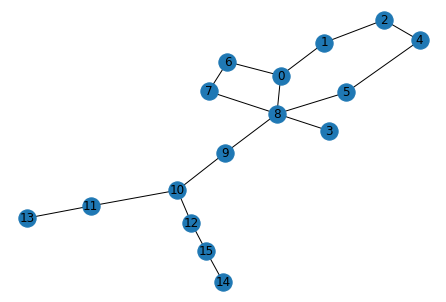

In [33]:
skeleton_graph = convert_skeleton_to_graph(skeleton)
nx.draw(skeleton_graph,with_labels=True)

In [40]:
skeleton_graph.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))

In [41]:
np.setdiff1d([16,15],skeleton_graph.nodes())

array([16])

In [43]:
from skeleton_utils import *

skeleton = su.decompress_pickle("remove_cycles_skeleton")
max_cycle_distance = 5000
verbose = False
check_cycles_at_end=True
return_original_if_error=False

#A) Convert the skeleton into a graph
skeleton_graph = convert_skeleton_to_graph(skeleton)
#B) Find all cycles in the graph
cycles_list = xu.find_all_cycles(skeleton_graph)

number_skipped = 0
for j,cyc in enumerate(cycles_list):
    if verbose:
        print(f"\n ---- Working on cycle {j}: {cyc} ----")
    #1) Get the length of the cycle 
    #--> if length if too big then skip
    cyc = np.array(cyc)
    
    if len(np.setdiff1d(cyc,skeleton_graph.nodes()))>0:
        print(f"--- cycle {i} has nodes that don't exist anymore so skipping --")
        continue

    sk_dist_of_cycle = xu.find_skeletal_distance_along_graph_node_path(skeleton_graph,cyc)

    if max_cycle_distance < sk_dist_of_cycle:
        if verbose:
            print(f"Skipping cycle {j} because total distance ({sk_dist_of_cycle}) is larger than max_cycle_distance ({max_cycle_distance}): {cyc} ")
        number_skipped += 1
        continue


    #Find the degrees of all of the nodes
    node_degrees = np.array([xu.get_node_degree(skeleton_graph,c) for c in cyc])
    print(f"node_degrees = {node_degrees}")

    #2) If only 1 high degree node, then just delete the other non high degree nodes
    if np.sum(node_degrees>2) == 1:
        if verbose:
            print(f"Deleting non-high degree nodes in cycle {j}: {cyc} becuase there was only one high degree node: {node_degrees}")
        nodes_to_delete = cyc[np.where(node_degrees<=2)[0]]

        skeleton_graph.remove_nodes_from(nodes_to_delete)
        continue


    #3) Else, there should only be 2 high degree nodes in the vertices of the cycle
    #--> if more or less then skip

    if np.sum(node_degrees>2) > 2:
        if verbose:
            print(f"Skipping cycle {j} because had {np.sum(node_degrees>2)} number of high degree nodes: {node_degrees} ")
        number_skipped += 1
        continue

    high_degree_nodes = cyc[np.where(node_degrees>2)[0]]
    cycle_graph = skeleton_graph.subgraph(cyc)

    #3) Get the 2 paths between the high degree nodes
    both_paths = list(nx.all_simple_paths(cycle_graph,high_degree_nodes[0],high_degree_nodes[1],len(cycle_graph)))

    if len(both_paths) != 2:
        su.compressed_pickle(skeleton,"skeleton")
        raise Exception(f"Did not come up with only 2 paths between high degree nodes: both_paths = {both_paths} ")

    path_lengths = [xu.find_skeletal_distance_along_graph_node_path(skeleton_graph,g) for g in both_paths]


    #4) Delete nodes on the path for the longer distance one
    longest_path_idx = np.argmax(path_lengths)
    longest_path = both_paths[longest_path_idx]
    if len(longest_path) <= 2:
        raise Exception(f"Longest path for deletion was only of size 2 or less: both_paths = {both_paths}, longest_path = {longest_path}")

    if verbose:
        print(f"For cycle {j} deleting the following path because longest distance {path_lengths[longest_path_idx]}: {longest_path[1:-1]}")

    skeleton_graph.remove_nodes_from(longest_path[1:-1])


#C) check that all cycles removed except for those ones
if check_cycles_at_end:
    cycles_at_end = xu.find_all_cycles(skeleton_graph)
    if number_skipped != len(cycles_at_end):
        print(f"The number of cycles skipped ({number_skipped}) does not equal the number of cycles at the end ({len(cycles_at_end)})")
#C) convert the graph back into a skeleton
skeleton_removed_cycles = convert_graph_to_skeleton(skeleton_graph)

node_degrees = [3 2 2 5]
node_degrees = [2 2 2 2 2 4]
--- cycle 1 has nodes that don't exist anymore so skipping --


In [44]:
nviz.plot_objects(skeletons=[skeleton_removed_cycles])

In [19]:
curr_meshes = [k["branch_mesh"] for k in limb_correspondence_individual.values()]
curr_skeletons = [k["branch_skeleton"] for k in limb_correspondence_individual.values()]
nviz.plot_objects(meshes=curr_meshes,
                 skeletons=curr_skeletons)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


In [16]:
nviz.plot_objects(mesh)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


In [ ]:
for sublimb_idx,(mesh,mesh_idx) in enumerate(zip(mesh_pieces_for_MAP,mesh_pieces_for_MAP_face_idx)):
    print(f"--- Working on MAP piece {sublimb_idx}---")
    mesh_start_time = time.time()
    curr_soma_to_piece_touching_vertices = filter_soma_touching_vertices_dict_by_mesh(
    mesh = mesh,
    curr_piece_to_soma_touching_vertices = soma_touching_vertices_dict
    )

    if print_fusion_steps:
        print(f"MAP Filtering Soma Pieces: {time.time() - fusion_time }")
        fusion_time = time.time()

    # ---- 0) Generating the Clean skeletons  -------------------------------------------#
    if not curr_soma_to_piece_touching_vertices is None:
        curr_total_border_vertices = dict([(k,np.vstack(v)) for k,v in curr_soma_to_piece_touching_vertices.items()])
    else:
        curr_total_border_vertices = None


    cleaned_branch,curr_limb_endpoints_must_keep = sk.skeletonize_and_clean_connected_branch_CGAL(
        mesh=mesh,
        curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
        total_border_vertices=curr_total_border_vertices,
        filter_end_node_length=filter_end_node_length,
        perform_cleaning_checks=perform_cleaning_checks,
        combine_close_skeleton_nodes = combine_close_skeleton_nodes,
        combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold,
    use_surface_after_CGAL=use_surface_after_CGAL,
    surface_reconstruction_size=surface_reconstruction_size)

In [ ]:
processed_mesh = tu.load_mesh_no_processing("/notebooks/Platinum_Decomp_Fusion/temp/None_0.off")
nviz.plot_objects(processed_mesh)

In [ ]:
current_mesh = su.decompress_pickle("current_mesh")
vertex_coordinates = su.decompress_pickle("vertex_coordinates")
nviz.plot_objects(current_mesh,
                 scatters=[vertex_coordinates])

In [ ]:
tu = reload(tu)
tu.vertices_coordinates_to_faces(current_mesh,vertex_coordinates)

In [ ]:
nviz.plot_objects(limb_mesh_mparty)

In [ ]:
nviz.plot_soma_limb_concept_network(neuron_obj)

In [ ]:
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")

# Sending the data to the Neuron Object

In [ ]:
nru = reload(nru)
save_time = time.time()
neuron_obj.save_compressed_neuron(output_folder="/notebooks/test_neurons/Fusion_decomp/",
                                 export_mesh=True,
                                 suppress_output=True)
print(f"Save time = {time.time() - save_time}")

In [ ]:
import neuron_visualizations as nviz
returned_colors = nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L6="all"),
                                       return_color_dict=True)